In [11]:
import torch
import torch.nn as nn
import torch.utils.data
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
import operator

from PIL import Image

In [12]:
device = torch.device('cuda')

num_channels = 5
batch_size = 4

In [13]:
def prod(iterable):
    return reduce(operator.mul, iterable, 1)
  
class NetCNN(nn.Module):
    def __init__(self, input_shape, output_dim):
        super().__init__()
        if (len(input_shape) != 3):
            raise ValueError('Expecting an input_shape representing dimensions CxHxW')
        self._input_channels = input_shape[0]
        print('input_channels: {}'.format(self._input_channels))
        self._conv2d1 = nn.Conv2d(in_channels=self._input_channels, out_channels=64, kernel_size=3)
        self._conv2d2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self._cnn_output_dim = self._cnn(torch.zeros(input_shape).unsqueeze(0)).nelement()
        print('cnn_output_dim: {}'.format(self._cnn_output_dim))
        self._fc1 = nn.Linear(self._cnn_output_dim, 256)
        self._fc2 = nn.Linear(256, output_dim)
        
    def _cnn(self, x):
        x = self._conv2d1(x)
        x = torch.relu(x)
        x = nn.MaxPool2d(kernel_size=3)(x)
        x = self._conv2d2(x)
        x = nn.MaxPool2d(kernel_size=3)(x)
        return x
    
    
    def forward(self, x):
        batch_dim = x.shape[0]
        x = self._cnn(x).view(batch_dim, -1)
        x = self._fc1(x)
        x = torch.relu(x)
        x = self._fc2(x)
        x = torch.sigmoid(x)
        return x
    
class NetFF(nn.Module):
    def __init__(self, input_shape, output_dim):
        super().__init__()
        if (len(input_shape) != 3):
            raise ValueError('Expecting an input_shape representing dimensions CxHxW')
        self._input_channels = input_shape[0]
        print('input_channels: {}'.format(self._input_channels))
        self._input_dim = prod(input_shape)
        print('input_dim: {}'.format(self._input_dim))
        self._fc1 = nn.Linear(self._input_dim, 64)
        self._fc2 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = x.view(-1, self._input_dim)
        x = self._fc1(x)
        x = torch.relu(x)
        x = self._fc2(x)
        x = torch.sigmoid(x)
        return x

def run_experiment(name, sun_maker_func, debug_out=False):
  sun = sun_maker_func(num_channels)
  sun_numpy = sun.cpu().numpy()

  if debug_out:
    for channel in sun_numpy:
        plt.imshow(channel, norm=None, cmap='hot', vmin=sun_numpy.min(), vmax=sun_numpy.max())
        plt.show()

  model = NetCNN(input_shape=[num_channels, 28, 28], output_dim=num_channels)
  model.cuda(device)
  model.train()
  optimizer = torch.optim.Adam(model.parameters())

  losses = []
  for b in range(1000):
      data = torch.cat([sun_maker_func(num_channels=num_channels) for i in range(batch_size)]).view(batch_size, num_channels, 28, 28)
      data_min, data_max = torch.min(data), torch.max(data)
      dim_factors = torch.rand(batch_size, num_channels).view(batch_size,-1).to(device)
  #     print(batch.shape)
  #     print(dim_factors.shape)
      dimmed_data = data.clone().to(device)
      for i in range(batch_size):
          for j in range(num_channels):
              dimmed_data[i, j] *= dim_factors[i, j]

      optimizer.zero_grad()
      output = model(dimmed_data)
      loss = nn.MSELoss()(output, dim_factors)
      loss.backward()
      optimizer.step()
      losses.append(float(loss))

      if b % 10 == 0:
          print('Current loss: {}'.format(float(loss)))
          sample = data[0].cpu().numpy()
          sample_dimmed = dimmed_data[0].cpu().numpy()

          if debug_out:
            for i, (channel, channel_dimmed) in enumerate(zip(sample, sample_dimmed)):
                fig = plt.figure()
                ax1 = fig.add_subplot(1, 3, 1)
                ax1.imshow(channel, norm=None, cmap='hot', vmin=data_min, vmax=data_max)
                ax2 = fig.add_subplot(1, 3, 2)
                ax2.imshow(channel_dimmed, norm=None, cmap='hot', vmin=data_min, vmax=data_max)
                ax3 = fig.add_subplot(1, 3, 3)
                ax3.imshow(channel_dimmed / float(output[0, i]), norm=None, cmap='hot', vmin=data_min, vmax=data_max)
                print('Channel: {} (left: original, middle: dimmed, right: undimmed)\nDimming (true): {}, dimming (predicted): {}'.format(i, dim_factors[0, i], output[0, i]))
                plt.show()
            dim_factors_numpy = dim_factors[0].view(-1).cpu().numpy()
            plt.plot(dim_factors_numpy, label='Dimming factors (true)')
            output_numpy = output[0].detach().view(-1).cpu().numpy()
            plt.plot(output_numpy, label='Dimming factors (predicted)')
            plt.legend()
            plt.show()

  if debug_out:
    plt.plot(losses, label='training loss')
    plt.show()
  print('Loss min: {}, max: {}, mean: {}'.format(min(losses), max(losses), np.mean(losses)))
  
  return np.mean(losses)

<img style="width: 50%; height: 50%;" src="experiment_quadrants.png" />

In [14]:
# How many times to run each experiment.
experiments_count = 5



----- Experiment Run 1


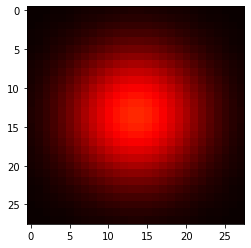

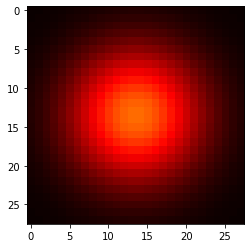

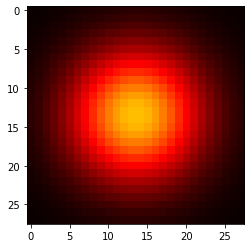

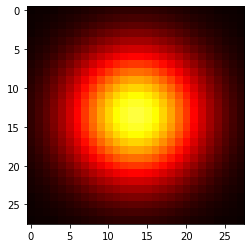

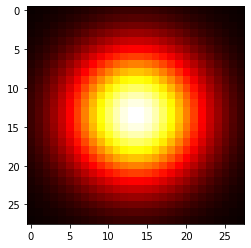

input_channels: 5
cnn_output_dim: 512
Current loss: 0.09064240753650665
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2128232717514038, dimming (predicted): 0.5062296390533447


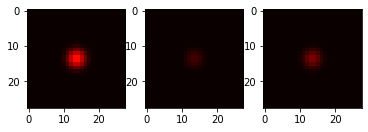

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8681504726409912, dimming (predicted): 0.5208073258399963


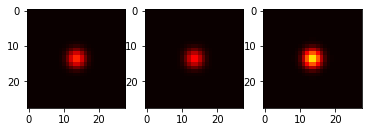

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.009184837341308594, dimming (predicted): 0.5043768882751465


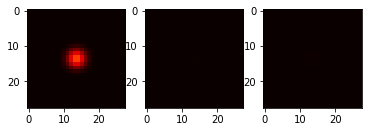

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6564458608627319, dimming (predicted): 0.4816114008426666


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2992329001426697, dimming (predicted): 0.521019458770752


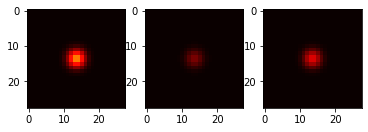

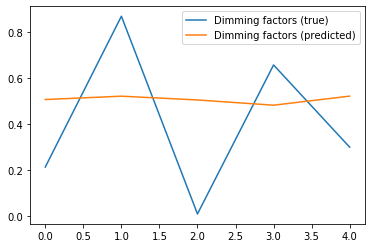

Current loss: 0.06922450661659241
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8077372312545776, dimming (predicted): 0.5026484131813049


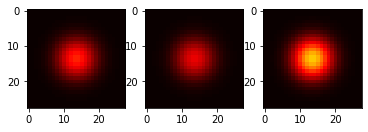

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.0007770657539367676, dimming (predicted): 0.5088651180267334


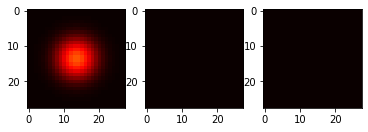

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.04162752628326416, dimming (predicted): 0.437656968832016


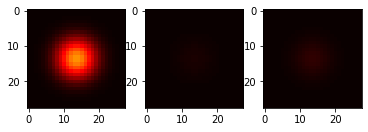

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5204010605812073, dimming (predicted): 0.510628879070282


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5252776741981506, dimming (predicted): 0.5049097537994385


Current loss: 0.07046553492546082
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3937809467315674, dimming (predicted): 0.4764866232872009


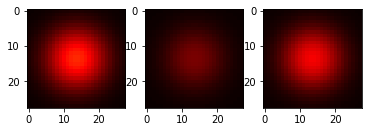

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8751180171966553, dimming (predicted): 0.3995091915130615


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5333676338195801, dimming (predicted): 0.44449231028556824


Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9288345575332642, dimming (predicted): 0.68158358335495


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.18828904628753662, dimming (predicted): 0.35956087708473206


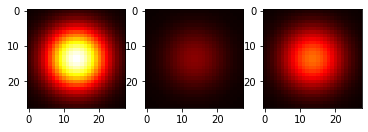

Current loss: 0.0602809302508831
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.08313018083572388, dimming (predicted): 0.1363362818956375


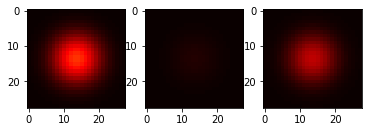

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8146030902862549, dimming (predicted): 0.5501642227172852


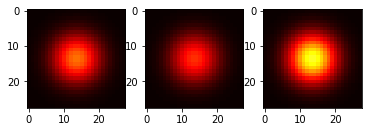

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8336771130561829, dimming (predicted): 0.8014795780181885


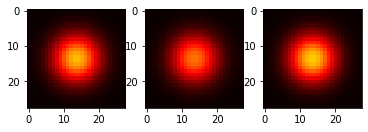

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8258652091026306, dimming (predicted): 0.7960023880004883


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4919024705886841, dimming (predicted): 0.3040678799152374


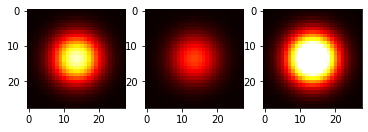

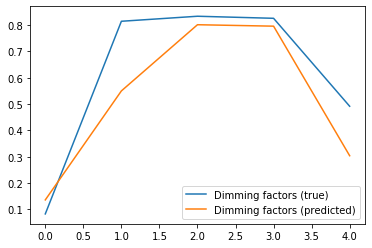

Current loss: 0.02532975748181343
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3892592787742615, dimming (predicted): 0.7284460067749023


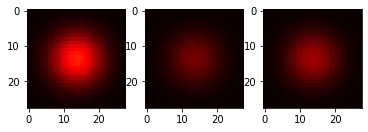

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6882709860801697, dimming (predicted): 0.48360195755958557


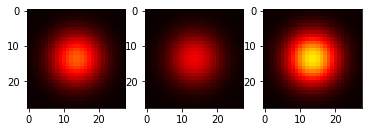

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8496962189674377, dimming (predicted): 0.8843607902526855


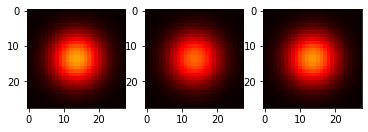

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.47679758071899414, dimming (predicted): 0.5442968010902405


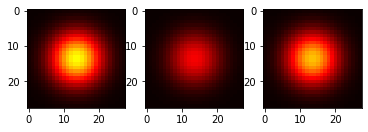

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.32537776231765747, dimming (predicted): 0.3233480751514435


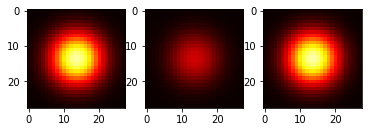

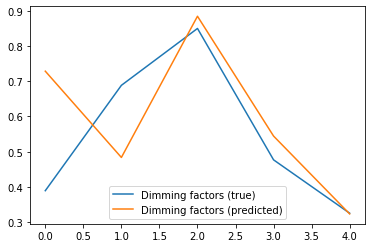

Current loss: 0.04175681620836258
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.33368808031082153, dimming (predicted): 0.2808699309825897


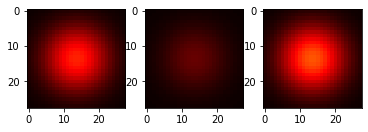

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4507354497909546, dimming (predicted): 0.36191093921661377


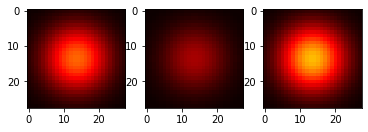

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8065622448921204, dimming (predicted): 0.9242599010467529


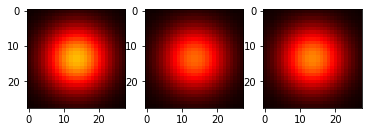

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.19695442914962769, dimming (predicted): 0.20198117196559906


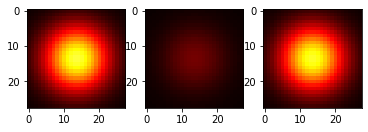

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9683852791786194, dimming (predicted): 0.8961315751075745


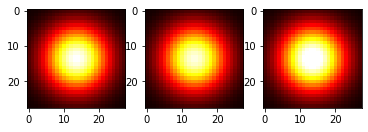

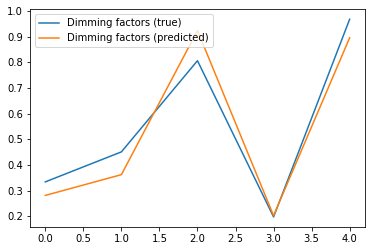

Current loss: 0.028607141226530075
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4074455499649048, dimming (predicted): 0.38390660285949707


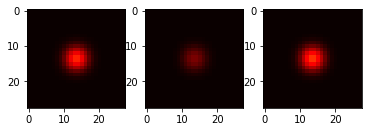

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5209124684333801, dimming (predicted): 0.33320969343185425


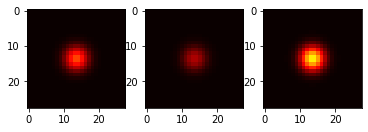

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.38422662019729614, dimming (predicted): 0.2557351589202881


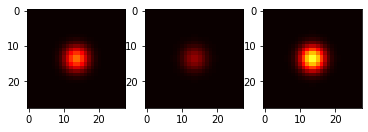

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7001938819885254, dimming (predicted): 0.7115002274513245


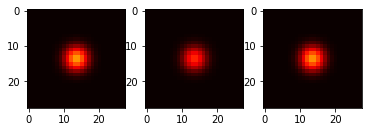

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9815188646316528, dimming (predicted): 0.7768646478652954


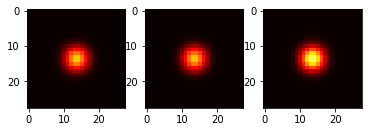

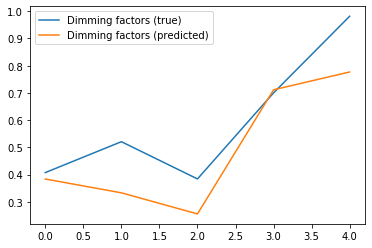

Current loss: 0.008833659812808037
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6419300436973572, dimming (predicted): 0.7389547228813171


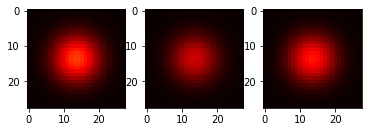

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.0142439603805542, dimming (predicted): 0.11708374321460724


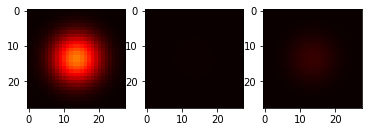

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8673042058944702, dimming (predicted): 0.9335141777992249


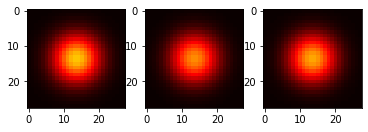

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.42727696895599365, dimming (predicted): 0.577665388584137


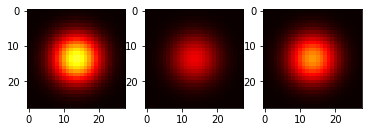

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.04447299242019653, dimming (predicted): 0.11340416967868805


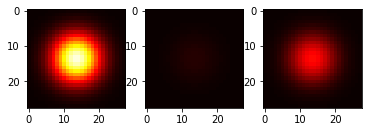

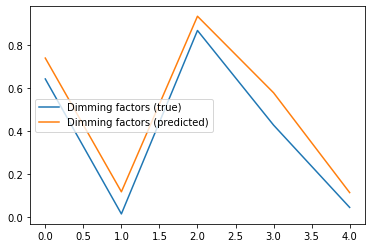

Current loss: 0.011156651191413403
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7039453983306885, dimming (predicted): 0.9106863737106323


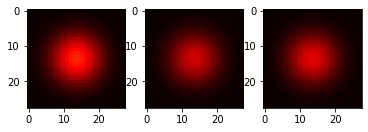

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.06530207395553589, dimming (predicted): 0.1171058937907219


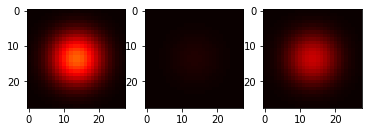

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.45006799697875977, dimming (predicted): 0.3929053544998169


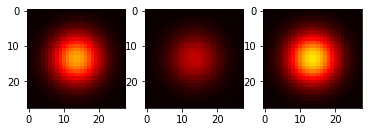

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6951730847358704, dimming (predicted): 0.7860739231109619


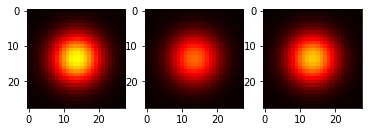

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.22739839553833008, dimming (predicted): 0.2798338830471039


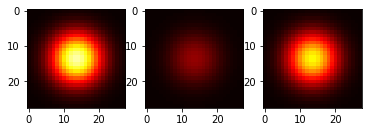

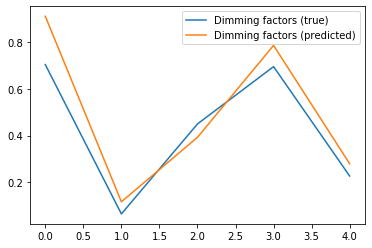

Current loss: 0.03823269158601761
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.05944192409515381, dimming (predicted): 0.45490512251853943


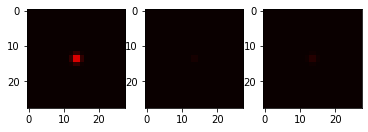

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4129599332809448, dimming (predicted): 0.43037915229797363


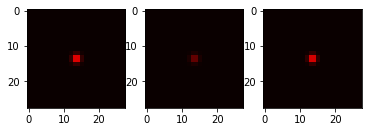

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.10349059104919434, dimming (predicted): 0.3713807761669159


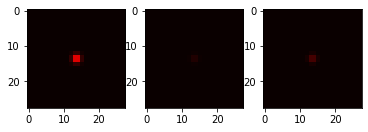

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7348930835723877, dimming (predicted): 0.4798765182495117


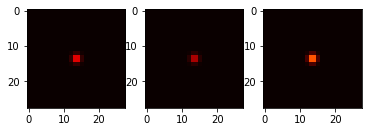

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.21956110000610352, dimming (predicted): 0.4175697863101959


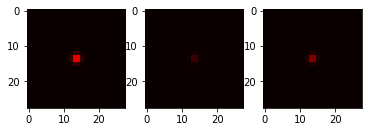

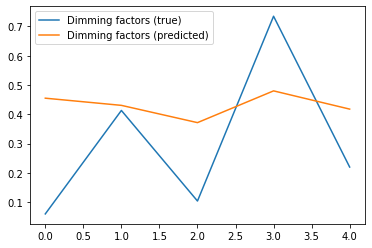

Current loss: 0.020302170887589455
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9647616147994995, dimming (predicted): 0.9252975583076477


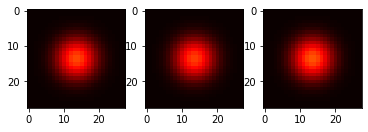

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.10155999660491943, dimming (predicted): 0.23894065618515015


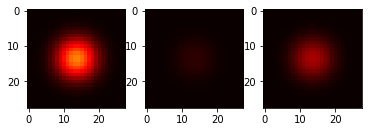

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1943008303642273, dimming (predicted): 0.31468522548675537


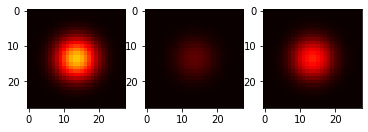

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.20637768507003784, dimming (predicted): 0.3421478271484375


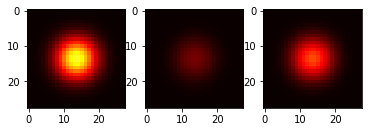

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.30131667852401733, dimming (predicted): 0.40220996737480164


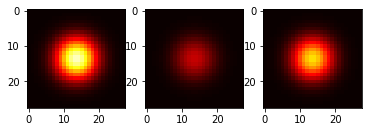

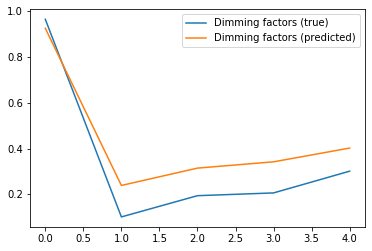

Current loss: 0.022102419286966324
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.019481897354125977, dimming (predicted): 0.13910828530788422


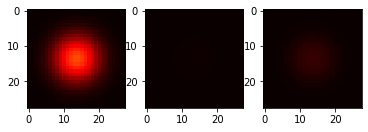

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.40310537815093994, dimming (predicted): 0.4451555013656616


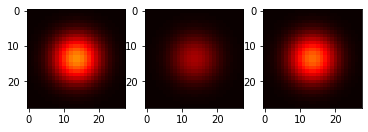

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7945616841316223, dimming (predicted): 0.9319396615028381


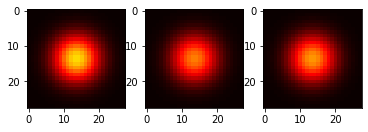

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1655483841896057, dimming (predicted): 0.1860799342393875


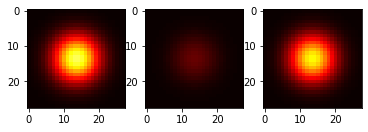

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7940210103988647, dimming (predicted): 0.8533931374549866


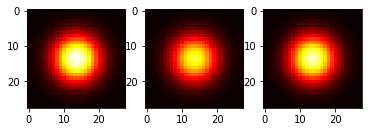

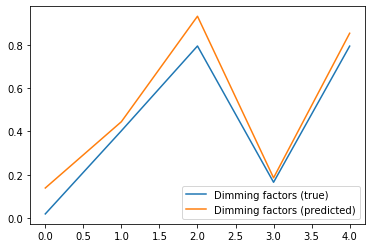

Current loss: 0.007024419493973255
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9979978203773499, dimming (predicted): 0.9619139432907104


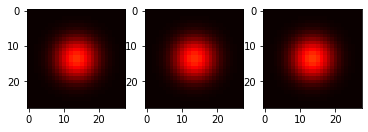

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.26795220375061035, dimming (predicted): 0.4804457724094391


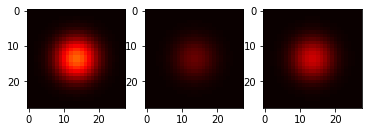

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.42902690172195435, dimming (predicted): 0.3755548596382141


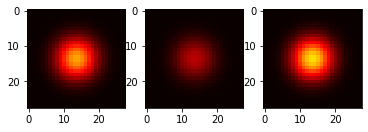

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.03631013631820679, dimming (predicted): 0.114798404276371


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.16492187976837158, dimming (predicted): 0.2207939773797989


Current loss: 0.06566070020198822
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.21448522806167603, dimming (predicted): 0.4832998812198639


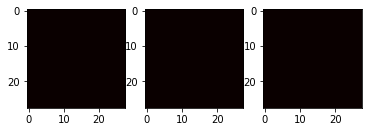

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8151842355728149, dimming (predicted): 0.45348936319351196


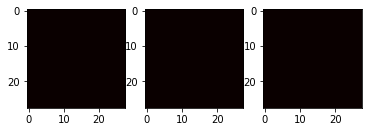

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9695176482200623, dimming (predicted): 0.4237167239189148


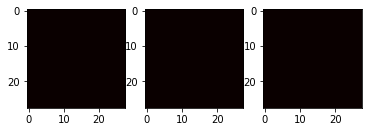

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6922465562820435, dimming (predicted): 0.38954049348831177


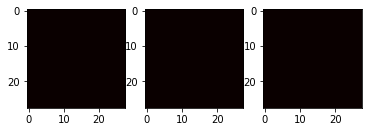

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9222831726074219, dimming (predicted): 0.5101821422576904


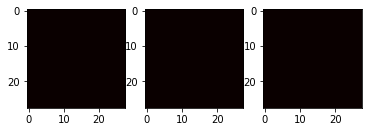

Current loss: 0.025596555322408676
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6695739030838013, dimming (predicted): 0.5810348987579346


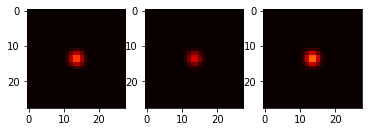

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.01607424020767212, dimming (predicted): 0.2070895880460739


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.741271436214447, dimming (predicted): 0.6215284466743469


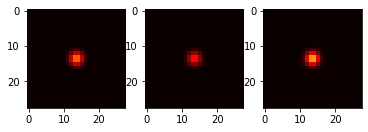

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.04574030637741089, dimming (predicted): 0.3485254645347595


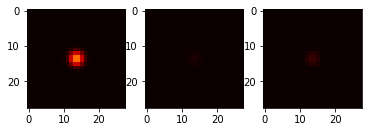

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.36947768926620483, dimming (predicted): 0.52719646692276


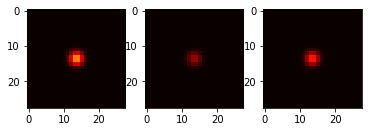

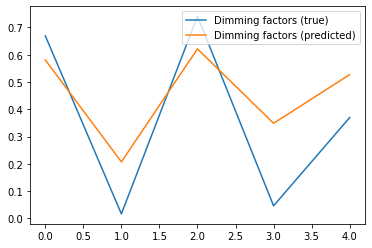

Current loss: 0.026058007031679153
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6719031929969788, dimming (predicted): 0.6609190702438354


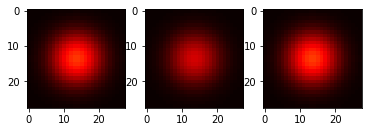

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4670114517211914, dimming (predicted): 0.5439537763595581


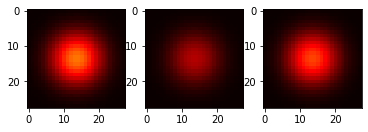

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.08406490087509155, dimming (predicted): 0.11800666898488998


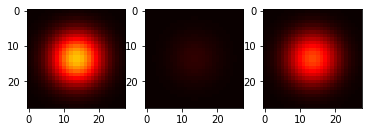

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7513651847839355, dimming (predicted): 0.8015033602714539


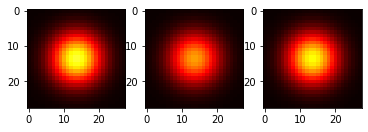

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6927001476287842, dimming (predicted): 0.728462815284729


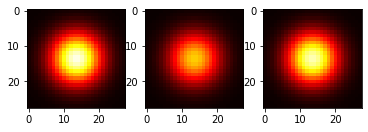

Current loss: 0.01586981676518917
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8418747186660767, dimming (predicted): 0.9837186932563782


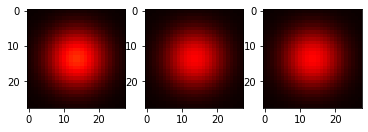

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.036556899547576904, dimming (predicted): 0.13258904218673706


Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.12069195508956909, dimming (predicted): 0.25898367166519165


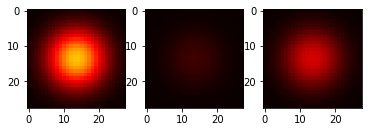

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.32093220949172974, dimming (predicted): 0.4116246700286865


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.031191468238830566, dimming (predicted): 0.10264577716588974


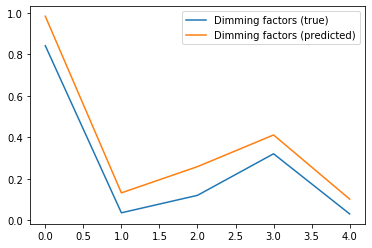

Current loss: 0.0264589823782444
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7104069590568542, dimming (predicted): 0.5238164067268372


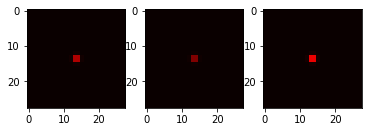

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5923870801925659, dimming (predicted): 0.40718942880630493


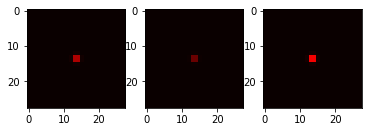

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.18465155363082886, dimming (predicted): 0.32720836997032166


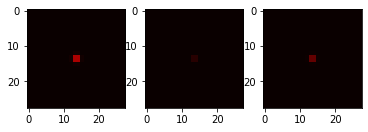

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.14227277040481567, dimming (predicted): 0.327838271856308


Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.911246657371521, dimming (predicted): 0.5911260843276978


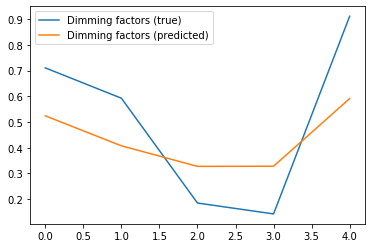

Current loss: 0.014436408877372742
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.14243650436401367, dimming (predicted): 0.29869791865348816


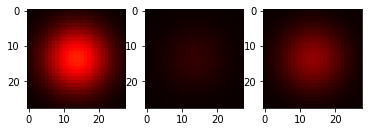

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7213311195373535, dimming (predicted): 0.8530223369598389


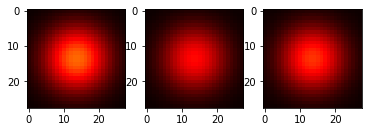

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.43885350227355957, dimming (predicted): 0.5309860706329346


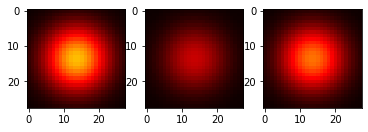

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.11544036865234375, dimming (predicted): 0.23960889875888824


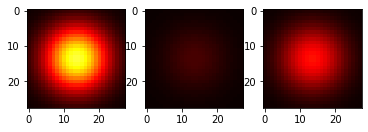

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.36538976430892944, dimming (predicted): 0.6380144953727722


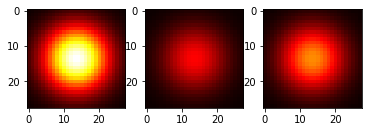

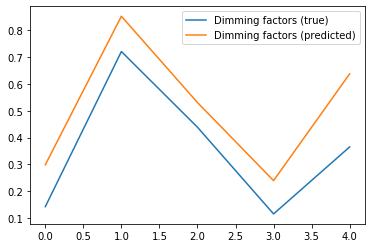

Current loss: 0.004820685833692551
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1103859543800354, dimming (predicted): 0.21499061584472656


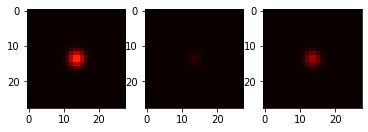

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.33620017766952515, dimming (predicted): 0.3124462962150574


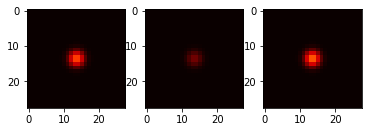

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8557621836662292, dimming (predicted): 0.8223004341125488


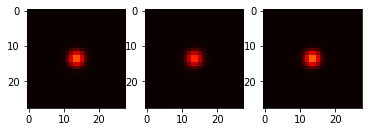

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.38210737705230713, dimming (predicted): 0.42964306473731995


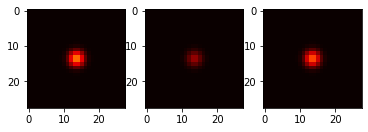

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9222513437271118, dimming (predicted): 0.7732850909233093


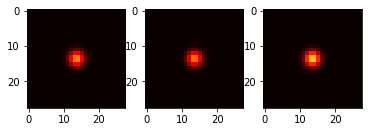

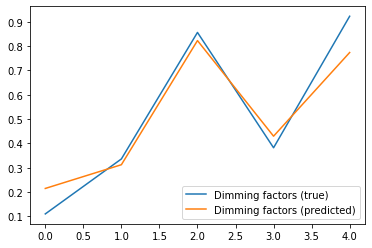

Current loss: 0.009149882011115551
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8121486306190491, dimming (predicted): 0.6837461590766907


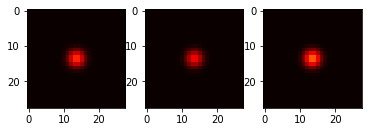

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8593661785125732, dimming (predicted): 0.8538191318511963


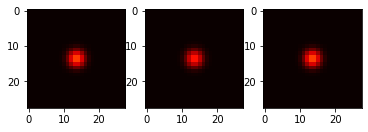

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.03456532955169678, dimming (predicted): 0.22511278092861176


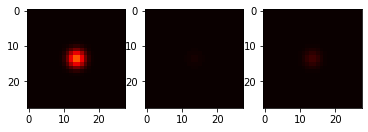

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.0007652044296264648, dimming (predicted): 0.1511658877134323


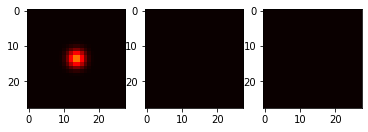

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5929126143455505, dimming (predicted): 0.5074276924133301


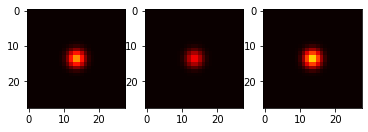

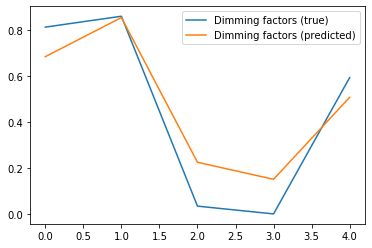

Current loss: 0.00284746615216136
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9367154240608215, dimming (predicted): 0.9432272911071777


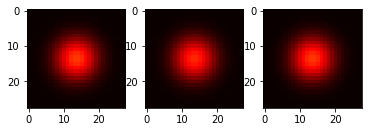

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.19920074939727783, dimming (predicted): 0.22791127860546112


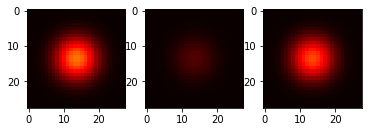

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5795344710350037, dimming (predicted): 0.6587195992469788


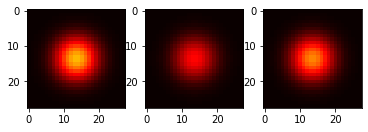

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.02490067481994629, dimming (predicted): 0.1327645629644394


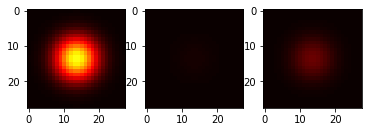

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.23899227380752563, dimming (predicted): 0.3145216107368469


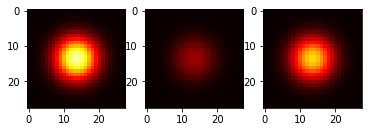

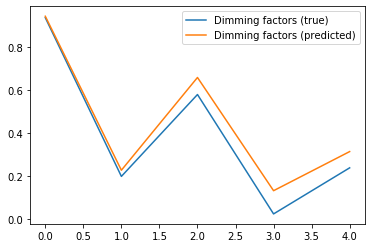

Current loss: 0.011003874242305756
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7629693746566772, dimming (predicted): 0.6624491214752197


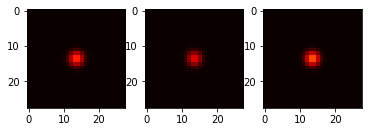

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7610790133476257, dimming (predicted): 0.6257081031799316


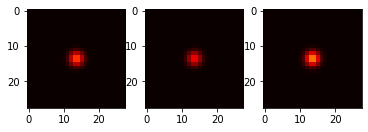

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.35001140832901, dimming (predicted): 0.2500840723514557


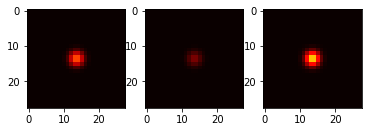

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9900363087654114, dimming (predicted): 0.7651017904281616


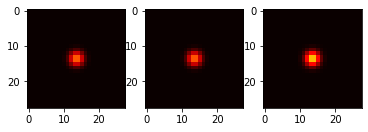

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6949631571769714, dimming (predicted): 0.683814287185669


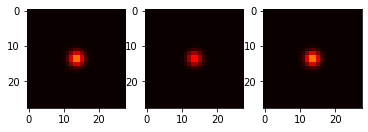

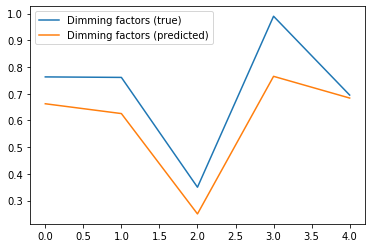

Current loss: 0.008136379532516003
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.06644177436828613, dimming (predicted): 0.02267535589635372


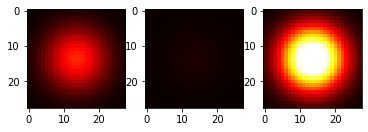

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.43250614404678345, dimming (predicted): 0.2601172924041748


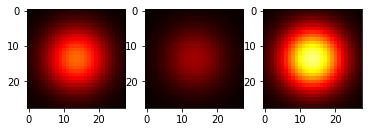

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7426313757896423, dimming (predicted): 0.7031141519546509


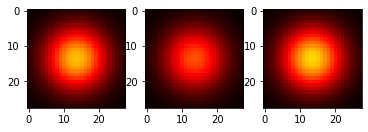

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6128058433532715, dimming (predicted): 0.6107835173606873


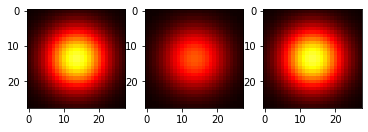

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8735555410385132, dimming (predicted): 0.867676854133606


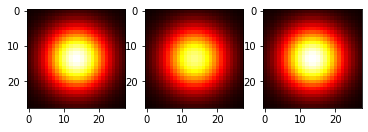

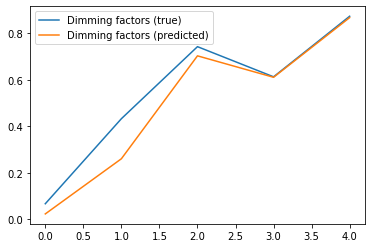

Current loss: 0.008010688237845898
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09175050258636475, dimming (predicted): 0.19998343288898468


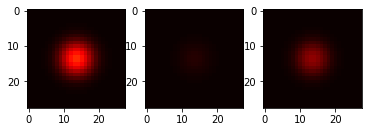

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.042667925357818604, dimming (predicted): 0.30299124121665955


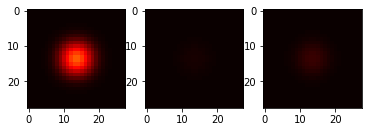

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.15281009674072266, dimming (predicted): 0.1882428675889969


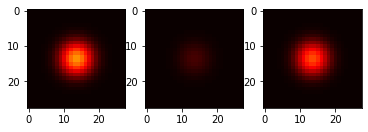

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2558860778808594, dimming (predicted): 0.30025357007980347


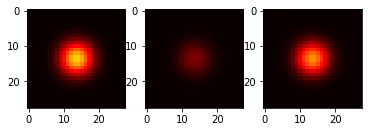

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8142563104629517, dimming (predicted): 0.9115134477615356


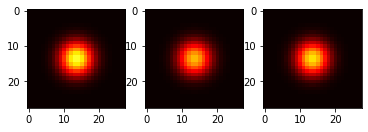

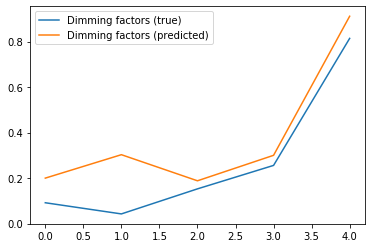

Current loss: 0.0181881133466959
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.27375227212905884, dimming (predicted): 0.6785426139831543


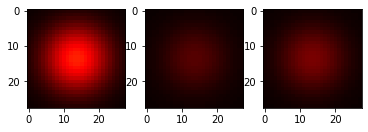

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.00850820541381836, dimming (predicted): 0.1589200496673584


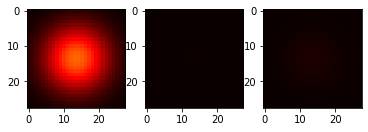

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.16754847764968872, dimming (predicted): 0.38502469658851624


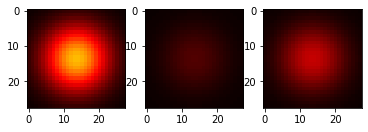

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09319674968719482, dimming (predicted): 0.24989305436611176


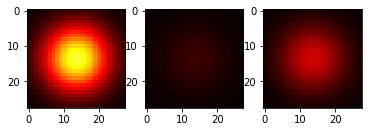

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.21155709028244019, dimming (predicted): 0.4260026812553406


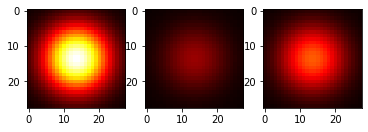

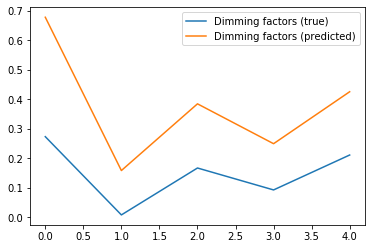

Current loss: 0.004911619238555431
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9249522089958191, dimming (predicted): 0.8569360375404358


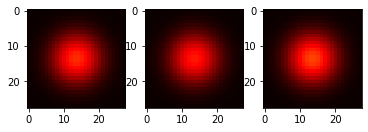

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9148120880126953, dimming (predicted): 0.8437030911445618


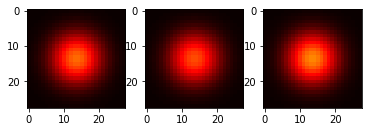

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6407254338264465, dimming (predicted): 0.7410183548927307


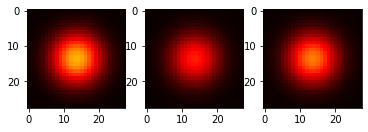

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6015195846557617, dimming (predicted): 0.6236176490783691


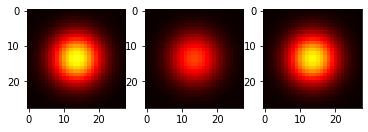

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.48891276121139526, dimming (predicted): 0.5718693733215332


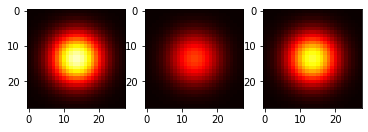

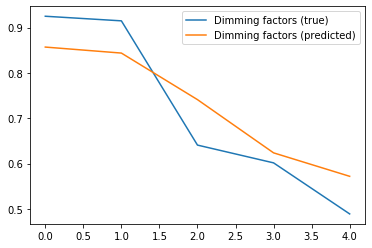

Current loss: 0.018475722521543503
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8880227208137512, dimming (predicted): 0.8334178328514099


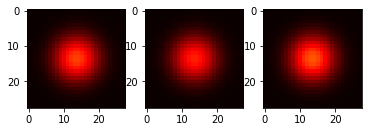

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7133675813674927, dimming (predicted): 0.7568421959877014


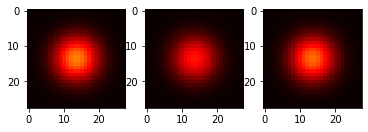

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5938370823860168, dimming (predicted): 0.4824642539024353


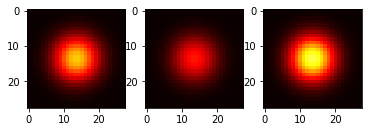

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6076791286468506, dimming (predicted): 0.5881431698799133


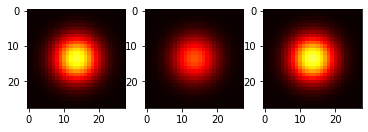

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9293563961982727, dimming (predicted): 0.8355200290679932


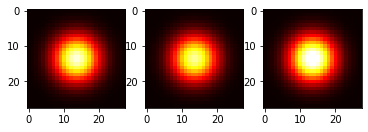

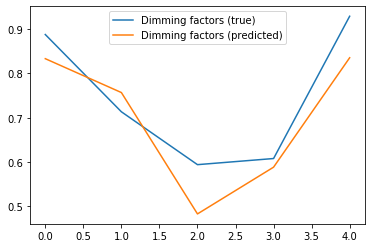

Current loss: 0.022293929010629654
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8265689015388489, dimming (predicted): 0.7779591083526611


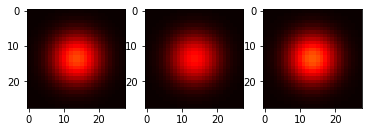

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7128123641014099, dimming (predicted): 0.6540337800979614


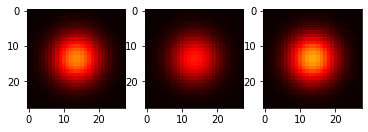

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.22967153787612915, dimming (predicted): 0.12303793430328369


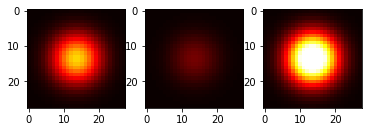

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5838720798492432, dimming (predicted): 0.4402037560939789


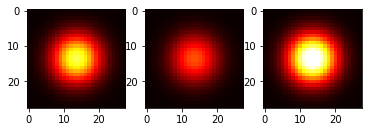

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5391664505004883, dimming (predicted): 0.5565831661224365


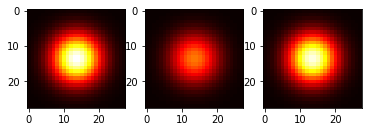

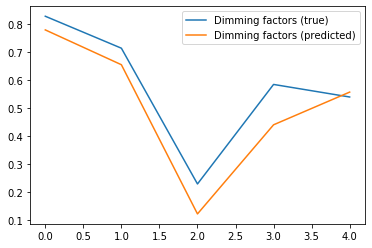

Current loss: 0.04656315594911575
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9747657179832458, dimming (predicted): 0.8862869143486023


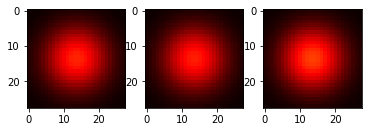

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.130933940410614, dimming (predicted): 0.07772516459226608


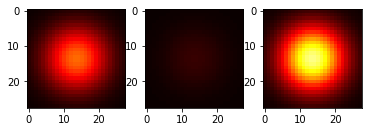

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1394239068031311, dimming (predicted): 0.07742879539728165


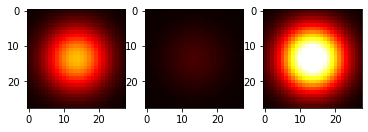

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5903825759887695, dimming (predicted): 0.6116290092468262


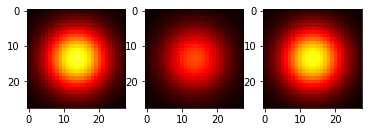

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7575243711471558, dimming (predicted): 0.6304236054420471


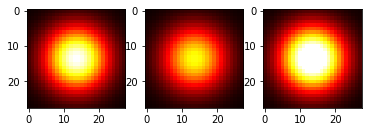

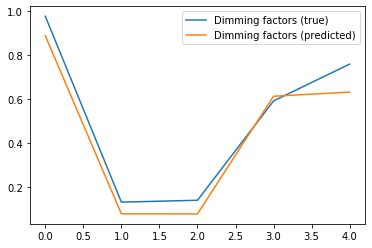

Current loss: 0.017437171190977097
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.25169527530670166, dimming (predicted): 0.17359034717082977


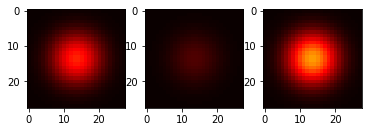

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3995874524116516, dimming (predicted): 0.2897041141986847


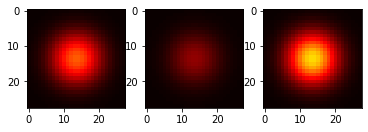

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4425038695335388, dimming (predicted): 0.19699011743068695


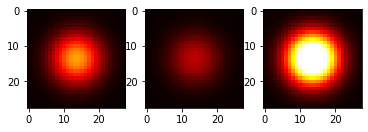

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9966335892677307, dimming (predicted): 0.9150322079658508


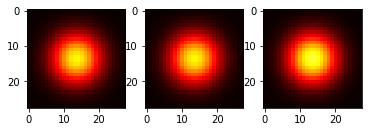

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5317772030830383, dimming (predicted): 0.5647918581962585


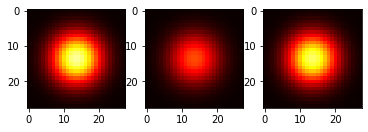

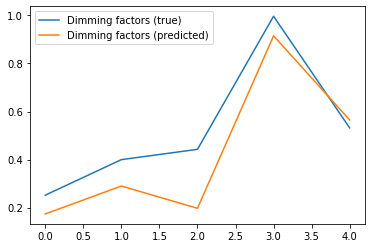

Current loss: 0.009540697559714317
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7451850175857544, dimming (predicted): 0.6754719614982605


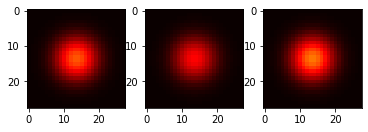

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.26101136207580566, dimming (predicted): 0.17949777841567993


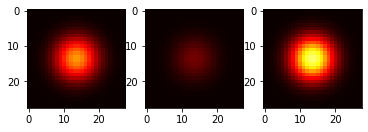

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8110735416412354, dimming (predicted): 0.8030471205711365


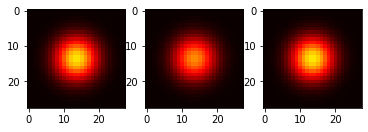

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6473875641822815, dimming (predicted): 0.5369758605957031


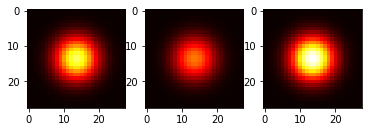

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6673101782798767, dimming (predicted): 0.6392822265625


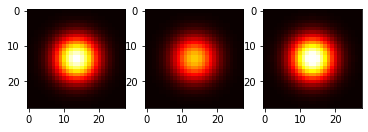

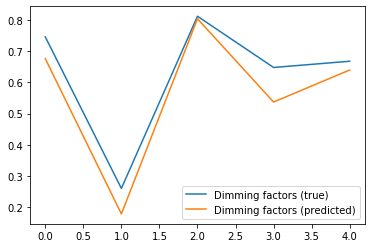

Current loss: 0.027611136436462402
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9815050959587097, dimming (predicted): 0.8234339356422424


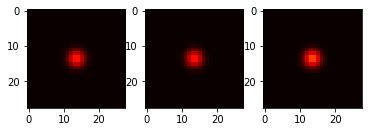

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9295873045921326, dimming (predicted): 0.8728845119476318


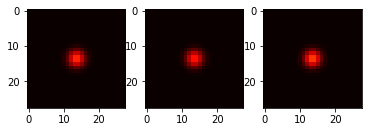

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.15803349018096924, dimming (predicted): 0.19772127270698547


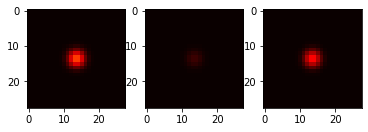

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.12278681993484497, dimming (predicted): 0.21100914478302002


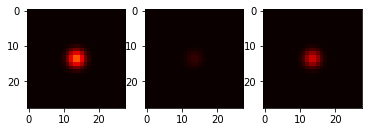

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.519866406917572, dimming (predicted): 0.5261055827140808


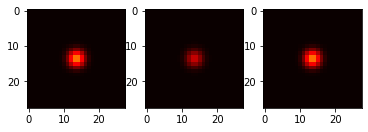

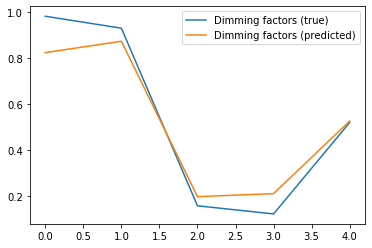

Current loss: 0.00912200752645731
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3766331076622009, dimming (predicted): 0.2725771367549896


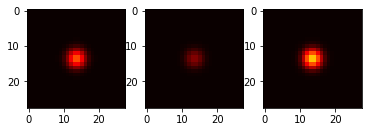

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2747567892074585, dimming (predicted): 0.13965262472629547


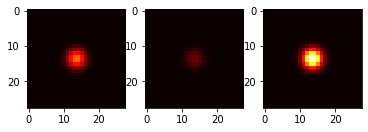

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9406182169914246, dimming (predicted): 0.9021564722061157


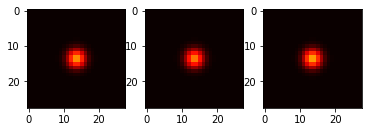

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.580267071723938, dimming (predicted): 0.4720940887928009


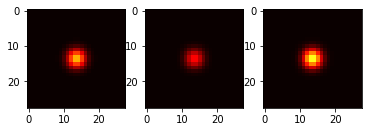

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.22578567266464233, dimming (predicted): 0.15803034603595734


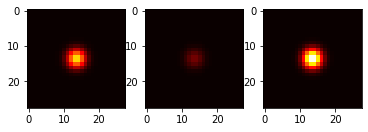

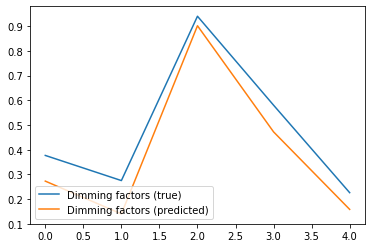

Current loss: 0.0073338961228728294
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5825899839401245, dimming (predicted): 0.5700703263282776


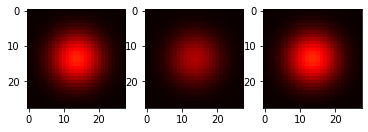

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.17369920015335083, dimming (predicted): 0.14451384544372559


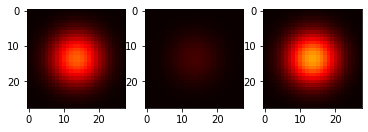

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.12168830633163452, dimming (predicted): 0.16653954982757568


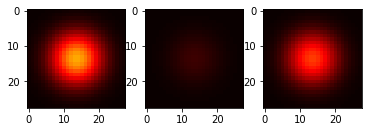

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.28240281343460083, dimming (predicted): 0.3153191804885864


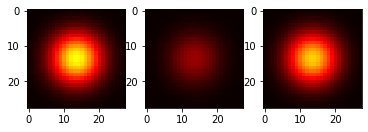

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.85605388879776, dimming (predicted): 0.8733983039855957


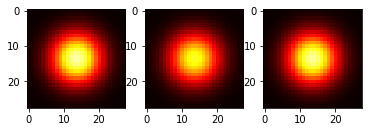

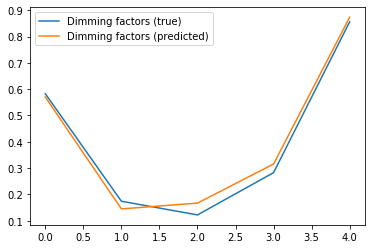

Current loss: 0.021226223558187485
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.36978524923324585, dimming (predicted): 0.23457498848438263


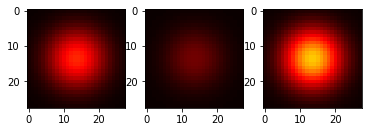

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4499889016151428, dimming (predicted): 0.27627286314964294


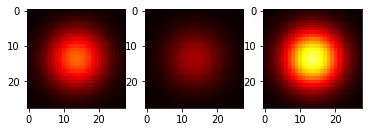

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7679744362831116, dimming (predicted): 0.675342321395874


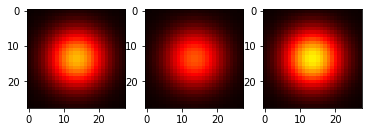

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8994284868240356, dimming (predicted): 0.7915146350860596


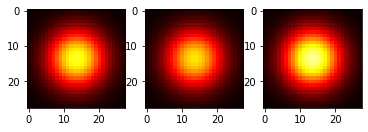

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8932061195373535, dimming (predicted): 0.8091242909431458


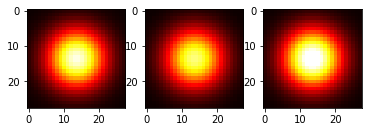

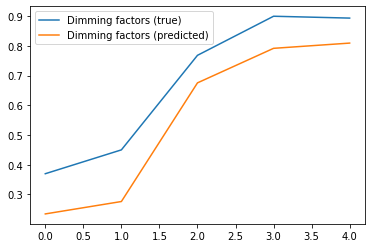

Current loss: 0.00976094976067543
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5565987229347229, dimming (predicted): 0.780249834060669


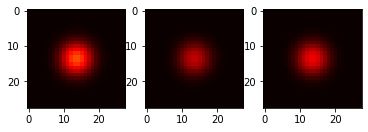

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3949263095855713, dimming (predicted): 0.48028743267059326


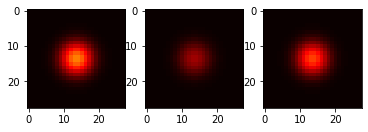

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.027087807655334473, dimming (predicted): 0.13219748437404633


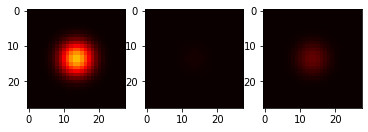

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.41761136054992676, dimming (predicted): 0.4973728060722351


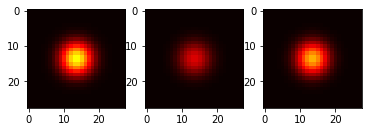

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.10979801416397095, dimming (predicted): 0.16630682349205017


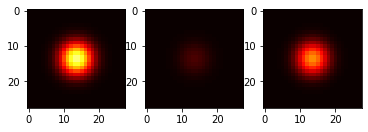

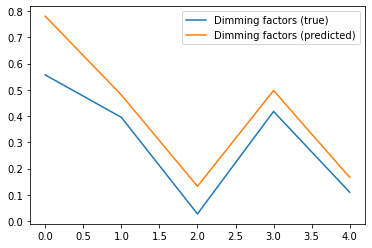

Current loss: 0.006730363704264164
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8376332521438599, dimming (predicted): 0.7912008166313171


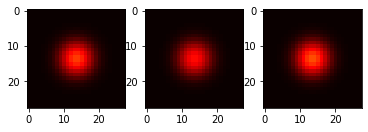

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3534421920776367, dimming (predicted): 0.43646639585494995


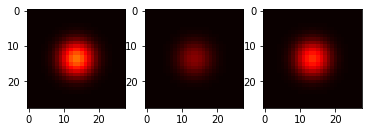

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09930509328842163, dimming (predicted): 0.10690911114215851


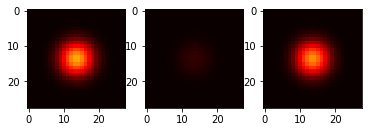

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9465157389640808, dimming (predicted): 0.9115844368934631


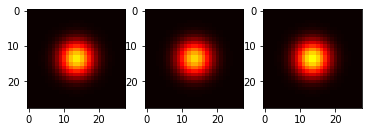

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9811800718307495, dimming (predicted): 0.917222797870636


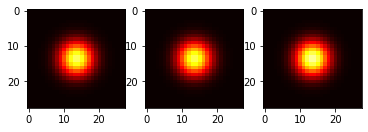

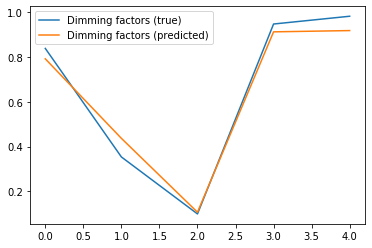

Current loss: 0.014124649576842785
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.0787423849105835, dimming (predicted): 0.2520822584629059


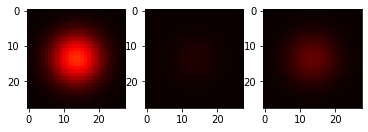

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3012051582336426, dimming (predicted): 0.5917300581932068


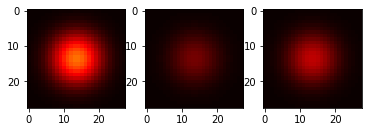

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.14224141836166382, dimming (predicted): 0.264397531747818


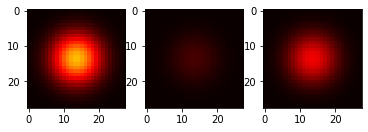

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09359800815582275, dimming (predicted): 0.2375415861606598


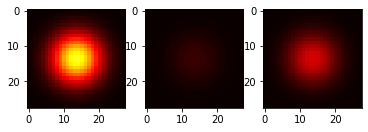

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.22486597299575806, dimming (predicted): 0.4488411545753479


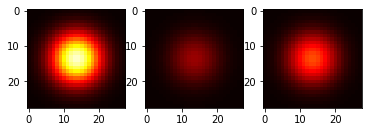

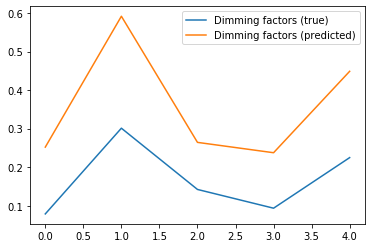

Current loss: 0.0056952014565467834
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.01648920774459839, dimming (predicted): 0.07850407809019089


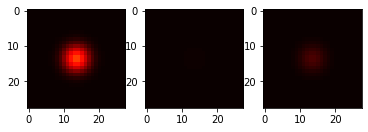

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9428991675376892, dimming (predicted): 0.8496561050415039


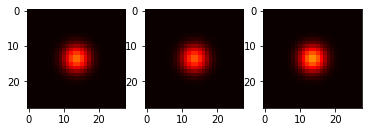

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6323162913322449, dimming (predicted): 0.6212003231048584


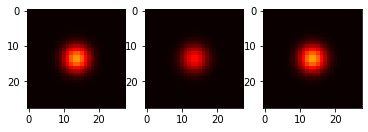

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4048035144805908, dimming (predicted): 0.3951526880264282


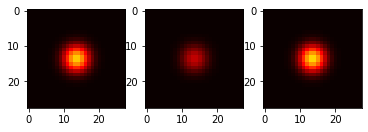

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.461936891078949, dimming (predicted): 0.43710699677467346


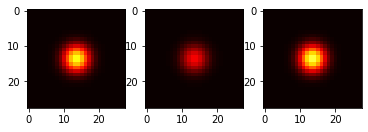

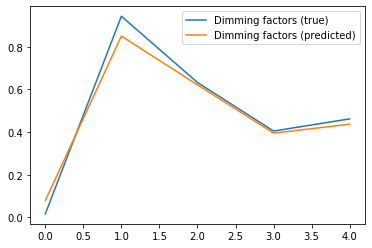

Current loss: 0.048843301832675934
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6828264594078064, dimming (predicted): 0.423056423664093


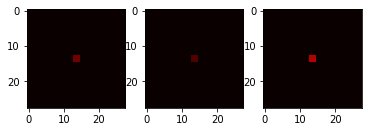

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5151335000991821, dimming (predicted): 0.39686012268066406


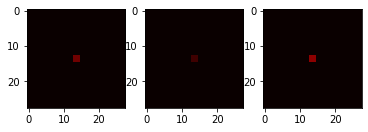

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.960554838180542, dimming (predicted): 0.3842424750328064


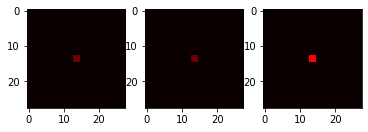

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7964221239089966, dimming (predicted): 0.3706207573413849


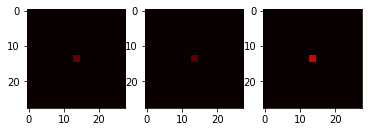

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9408032894134521, dimming (predicted): 0.4286158084869385


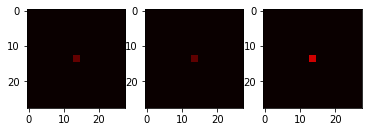

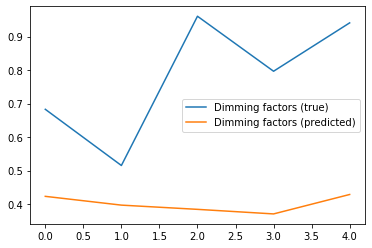

Current loss: 0.006483779288828373
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1590471863746643, dimming (predicted): 0.13367672264575958


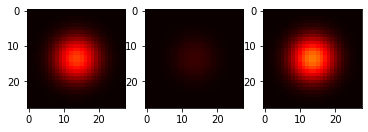

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.48020678758621216, dimming (predicted): 0.5613611936569214


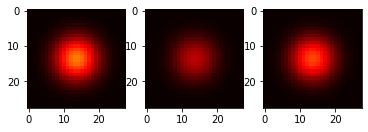

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6138752102851868, dimming (predicted): 0.6582728624343872


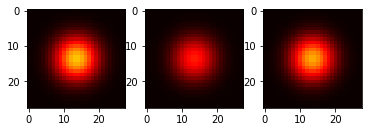

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.70415198802948, dimming (predicted): 0.768213152885437


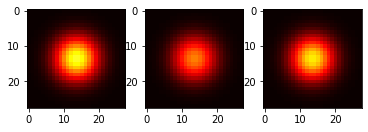

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7346657514572144, dimming (predicted): 0.7863136529922485


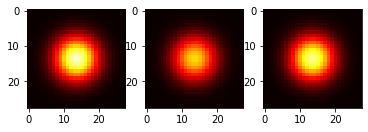

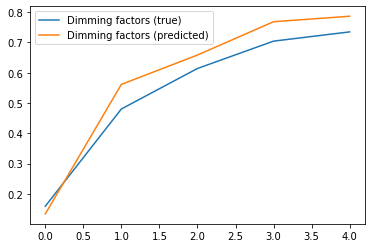

Current loss: 0.007423036731779575
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7457675337791443, dimming (predicted): 0.8096854090690613


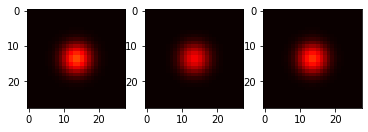

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7272554636001587, dimming (predicted): 0.7640023231506348


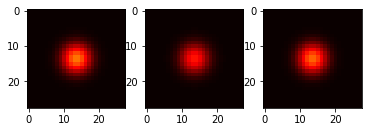

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2184680700302124, dimming (predicted): 0.18849188089370728


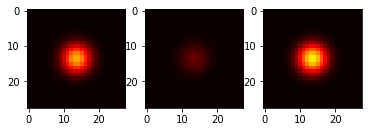

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.38009482622146606, dimming (predicted): 0.3807445168495178


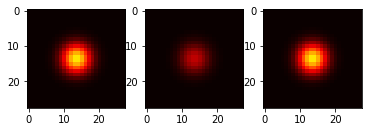

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.06279617547988892, dimming (predicted): 0.07018864154815674


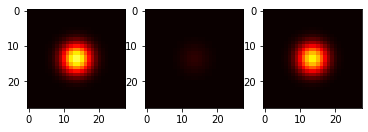

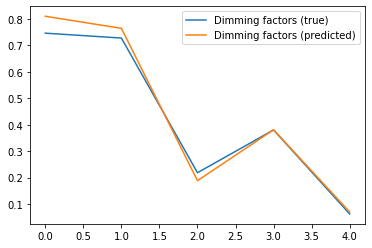

Current loss: 0.03304930776357651
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6545093655586243, dimming (predicted): 0.6287192106246948


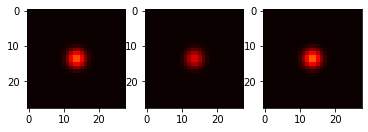

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.32053178548812866, dimming (predicted): 0.20212391018867493


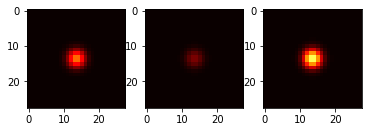

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8006213903427124, dimming (predicted): 0.8174883127212524


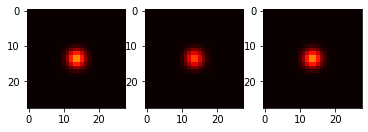

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7172690033912659, dimming (predicted): 0.7166664600372314


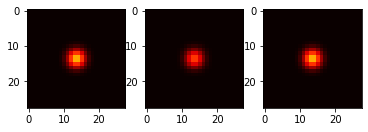

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6455715298652649, dimming (predicted): 0.7918046712875366


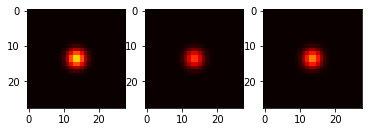

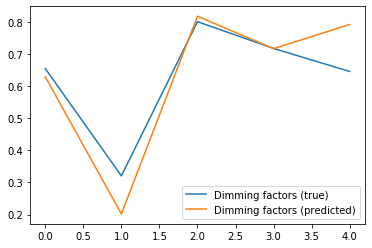

Current loss: 0.016166970133781433
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09197509288787842, dimming (predicted): 0.2608155608177185


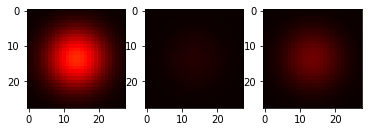

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8530591726303101, dimming (predicted): 0.8751137256622314


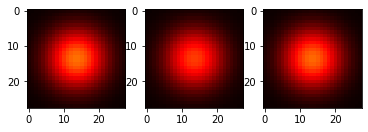

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5511677265167236, dimming (predicted): 0.6331253051757812


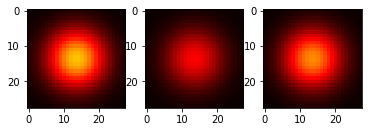

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.03855806589126587, dimming (predicted): 0.07828596979379654


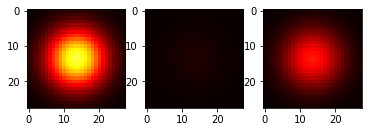

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8372544050216675, dimming (predicted): 0.8536761999130249


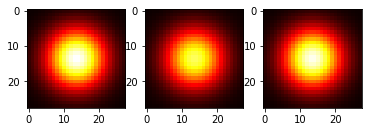

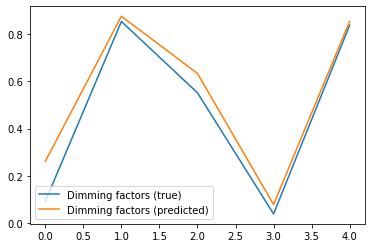

Current loss: 0.0037775933742523193
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.16908788681030273, dimming (predicted): 0.13303254544734955


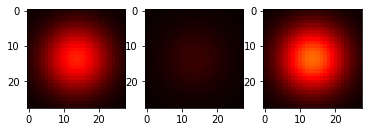

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2545994520187378, dimming (predicted): 0.1407865583896637


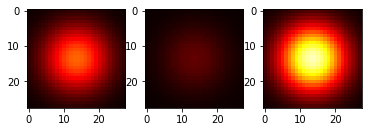

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.11818981170654297, dimming (predicted): 0.17566537857055664


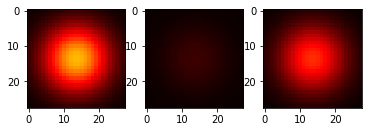

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8567830920219421, dimming (predicted): 0.9000792503356934


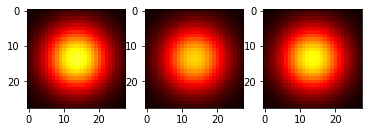

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7378076910972595, dimming (predicted): 0.7922400236129761


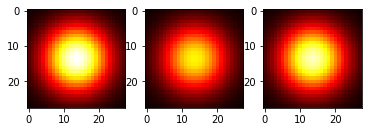

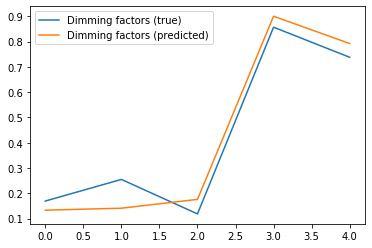

Current loss: 0.005505071021616459
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.34337109327316284, dimming (predicted): 0.45419758558273315


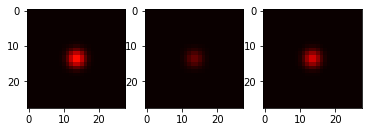

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.13414764404296875, dimming (predicted): 0.21618732810020447


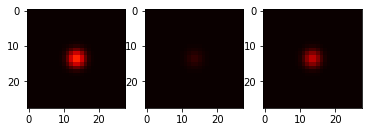

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5959827899932861, dimming (predicted): 0.7633628845214844


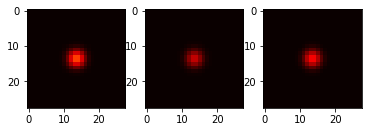

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.25008541345596313, dimming (predicted): 0.2944514751434326


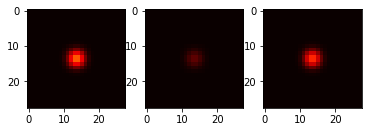

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8271737098693848, dimming (predicted): 0.9028916954994202


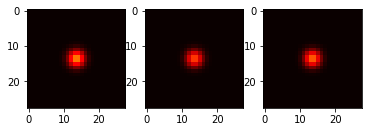

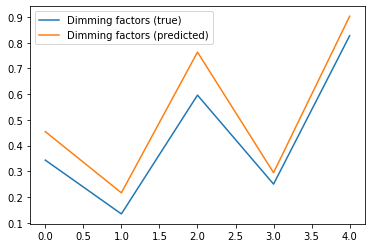

Current loss: 0.03594653308391571
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7528068423271179, dimming (predicted): 0.7658827900886536


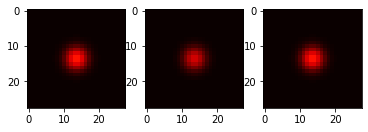

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.053179025650024414, dimming (predicted): 0.04189784452319145


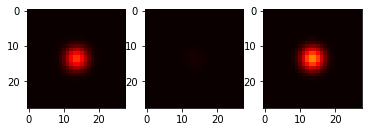

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.90875643491745, dimming (predicted): 0.8098260164260864


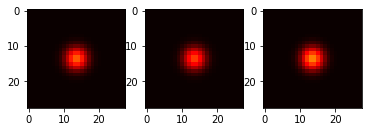

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6942339539527893, dimming (predicted): 0.6017328500747681


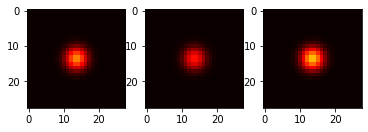

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4474864602088928, dimming (predicted): 0.42204293608665466


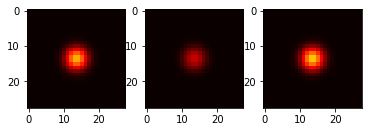

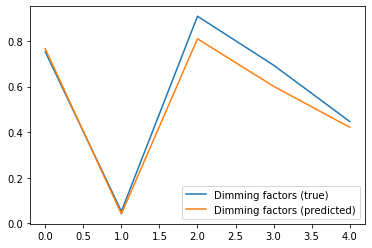

Current loss: 0.023854652419686317
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.659250020980835, dimming (predicted): 0.5925940871238708


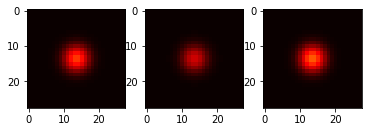

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9806694984436035, dimming (predicted): 0.9123198986053467


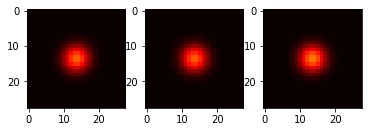

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.21195685863494873, dimming (predicted): 0.1712600737810135


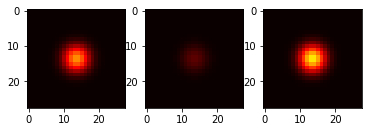

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.46953195333480835, dimming (predicted): 0.5188736319541931


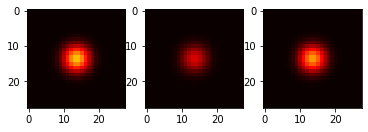

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4216115474700928, dimming (predicted): 0.32174152135849


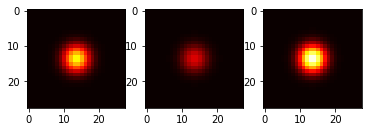

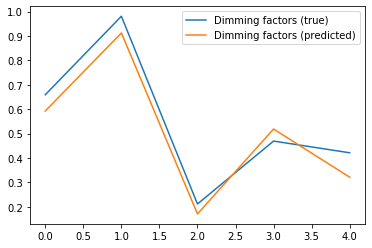

Current loss: 0.005823356099426746
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.009937286376953125, dimming (predicted): 0.08329390734434128


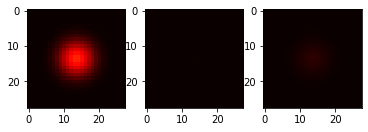

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5724357962608337, dimming (predicted): 0.6162919998168945


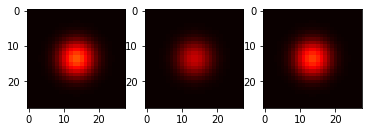

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4320296049118042, dimming (predicted): 0.506532609462738


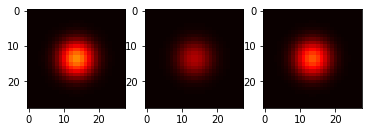

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6332244873046875, dimming (predicted): 0.7243186831474304


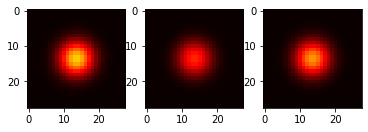

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.21677261590957642, dimming (predicted): 0.307159960269928


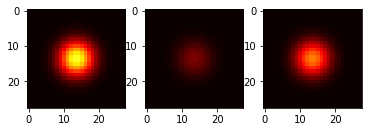

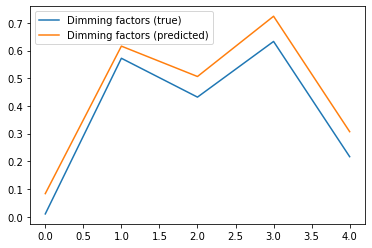

Current loss: 0.0046002985909581184
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.15412628650665283, dimming (predicted): 0.2239006757736206


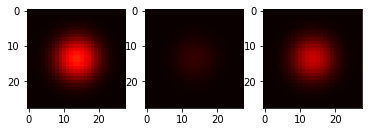

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.016739726066589355, dimming (predicted): 0.0683383122086525


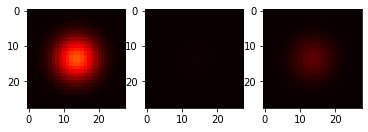

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4296676516532898, dimming (predicted): 0.6012194156646729


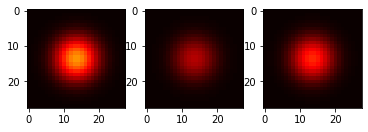

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.31724876165390015, dimming (predicted): 0.4598056674003601


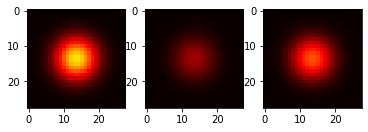

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3110443949699402, dimming (predicted): 0.34660089015960693


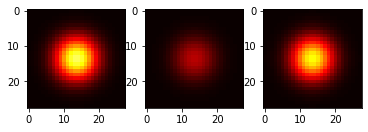

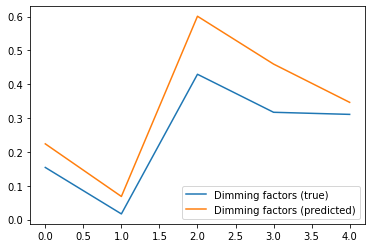

Current loss: 0.010621677152812481
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6460906267166138, dimming (predicted): 0.6957654356956482


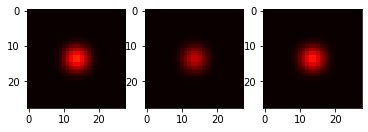

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9512667059898376, dimming (predicted): 0.9401978850364685


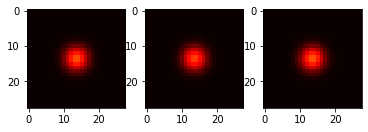

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.40889275074005127, dimming (predicted): 0.5370274186134338


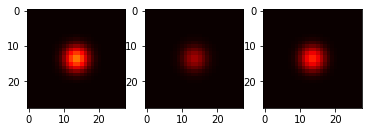

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.527574896812439, dimming (predicted): 0.511029839515686


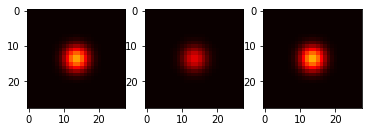

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6957910656929016, dimming (predicted): 0.7797024250030518


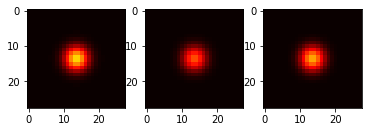

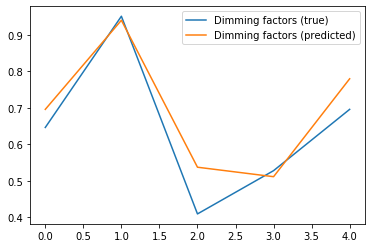

Current loss: 0.023271894082427025
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.310696542263031, dimming (predicted): 0.447615385055542


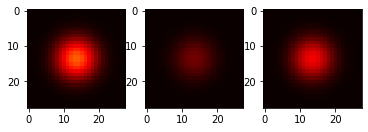

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.10358750820159912, dimming (predicted): 0.09201522916555405


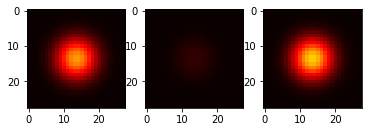

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.37391090393066406, dimming (predicted): 0.3714912533760071


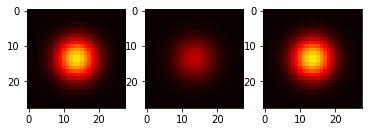

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3154446482658386, dimming (predicted): 0.3822254240512848


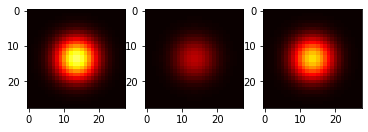

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6829977631568909, dimming (predicted): 0.7536130547523499


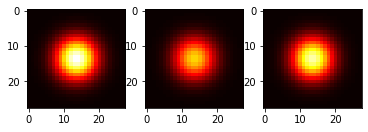

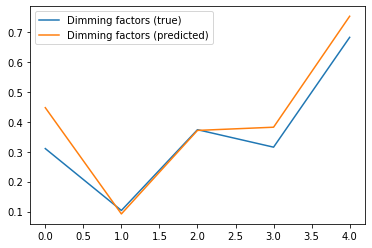

Current loss: 0.022980445995926857
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.0680152177810669, dimming (predicted): 0.5172649025917053


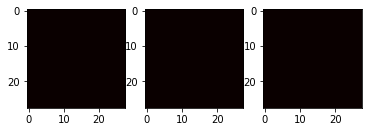

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.07985460758209229, dimming (predicted): 0.4142812192440033


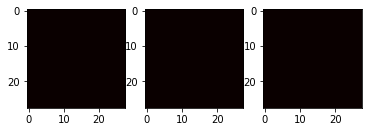

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5719618201255798, dimming (predicted): 0.46762871742248535


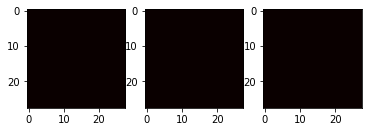

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2793629765510559, dimming (predicted): 0.4612443149089813


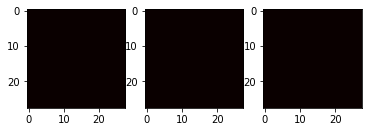

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.587806224822998, dimming (predicted): 0.452148973941803


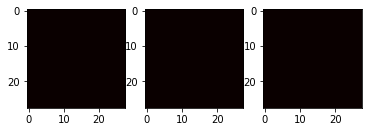

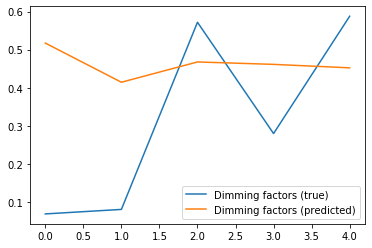

Current loss: 0.013440465554594994
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5739455223083496, dimming (predicted): 0.44183310866355896


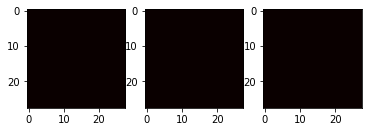

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5981895327568054, dimming (predicted): 0.38290831446647644


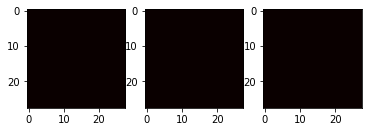

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6979638338088989, dimming (predicted): 0.4391649663448334


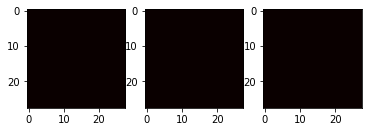

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6106664538383484, dimming (predicted): 0.43978673219680786


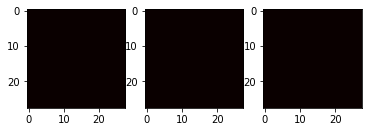

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6952174305915833, dimming (predicted): 0.45477718114852905


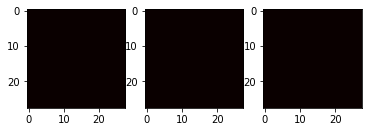

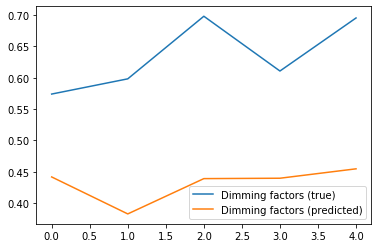

Current loss: 0.004568966571241617
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.18338829278945923, dimming (predicted): 0.1353197693824768


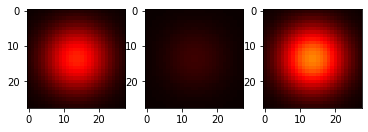

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8138177990913391, dimming (predicted): 0.88202965259552


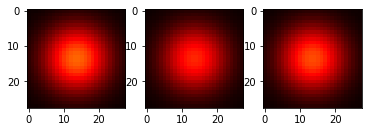

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7968571186065674, dimming (predicted): 0.8848816156387329


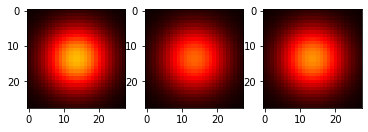

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8742331862449646, dimming (predicted): 0.9373746514320374


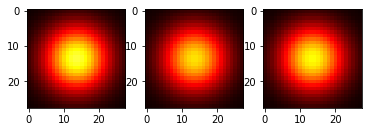

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6377497315406799, dimming (predicted): 0.7975192666053772


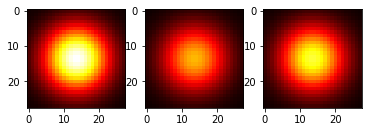

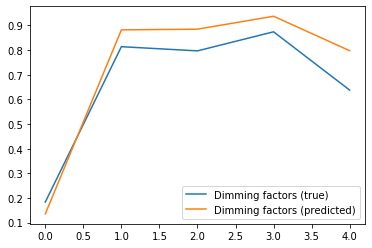

Current loss: 0.010357281193137169
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9657420516014099, dimming (predicted): 0.8426072001457214


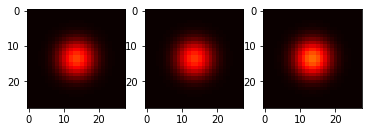

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.26463866233825684, dimming (predicted): 0.17295406758785248


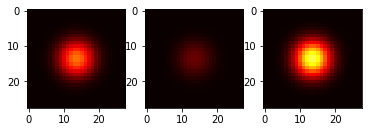

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7657997012138367, dimming (predicted): 0.691748321056366


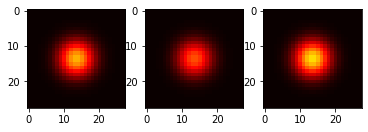

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5992256999015808, dimming (predicted): 0.4269547164440155


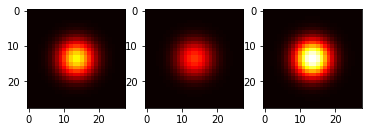

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5986435413360596, dimming (predicted): 0.46371880173683167


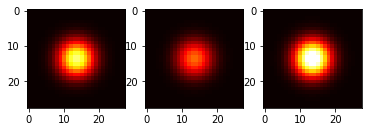

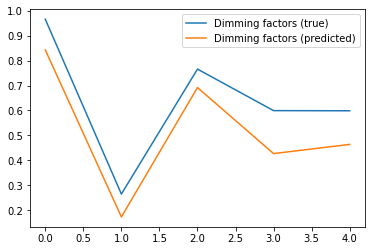

Current loss: 0.019728045910596848
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6883743405342102, dimming (predicted): 0.7310110926628113


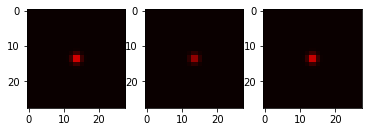

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3795347809791565, dimming (predicted): 0.33773961663246155


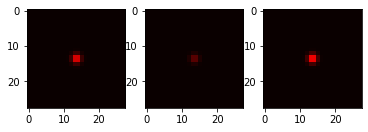

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.21115463972091675, dimming (predicted): 0.21843436360359192


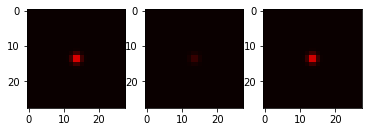

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7206993699073792, dimming (predicted): 0.7900161743164062


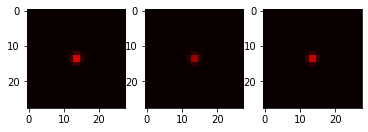

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8323737978935242, dimming (predicted): 0.710655927658081


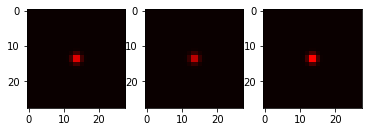

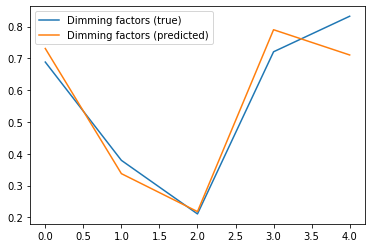

Current loss: 0.004267667420208454
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9557714462280273, dimming (predicted): 0.8665854930877686


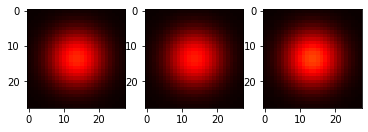

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.28708916902542114, dimming (predicted): 0.330426961183548


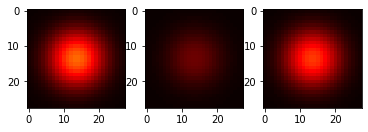

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6956248879432678, dimming (predicted): 0.7824703454971313


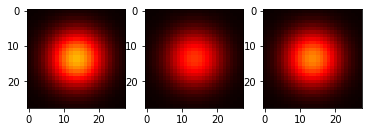

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7425870299339294, dimming (predicted): 0.7200354933738708


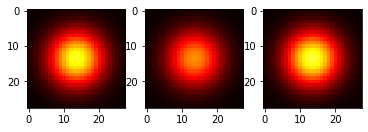

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2728235125541687, dimming (predicted): 0.22581183910369873


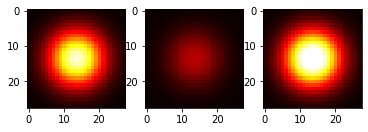

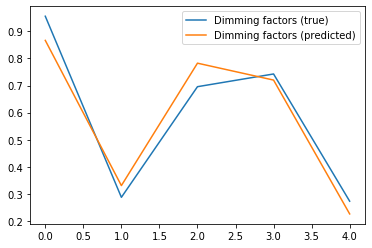

Current loss: 0.011096252128481865
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5995550155639648, dimming (predicted): 0.6906768083572388


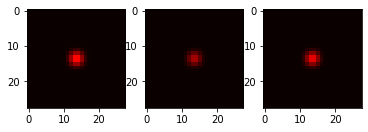

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.49874287843704224, dimming (predicted): 0.4541110396385193


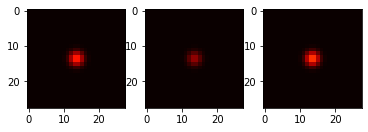

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.18256354331970215, dimming (predicted): 0.1503840982913971


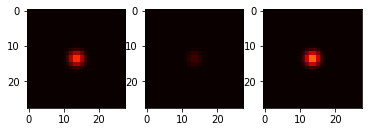

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9492044448852539, dimming (predicted): 0.9309206604957581


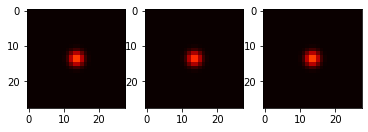

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6761363744735718, dimming (predicted): 0.7639716863632202


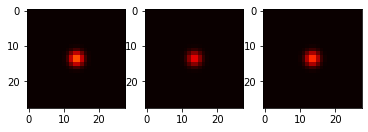

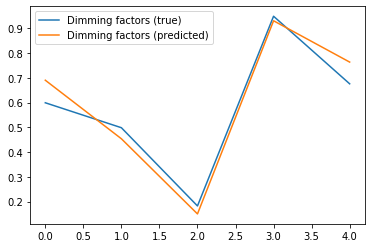

Current loss: 0.008288377895951271
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7408226132392883, dimming (predicted): 0.7522075176239014


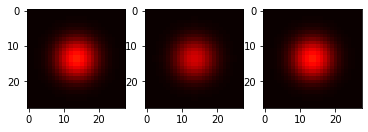

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.708484947681427, dimming (predicted): 0.7700729370117188


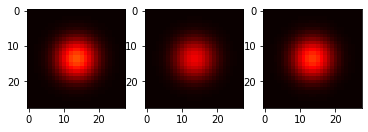

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4593226909637451, dimming (predicted): 0.4060078561306


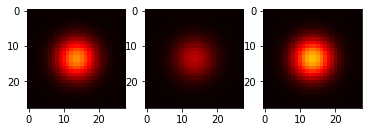

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8860006928443909, dimming (predicted): 0.8766181468963623


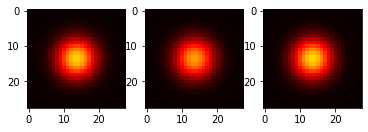

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8312123417854309, dimming (predicted): 0.8073317408561707


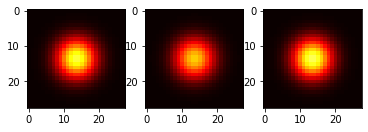

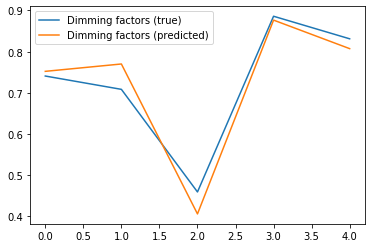

Current loss: 0.0028018453158438206
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.0015066266059875488, dimming (predicted): 0.054449208080768585


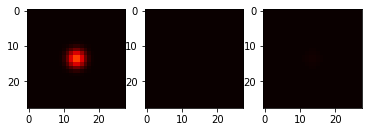

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9068318009376526, dimming (predicted): 0.9113448858261108


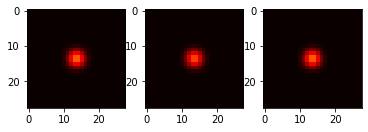

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6760523915290833, dimming (predicted): 0.7113816142082214


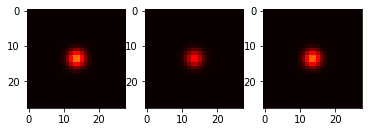

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9261577725410461, dimming (predicted): 0.8357717990875244


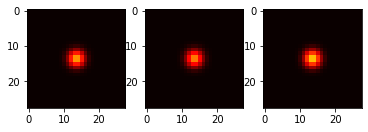

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.46788930892944336, dimming (predicted): 0.45656105875968933


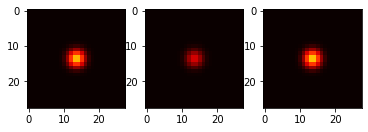

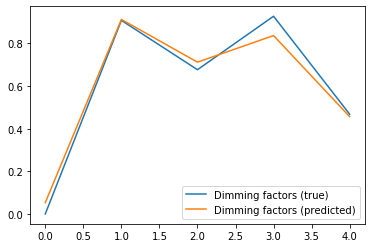

Current loss: 0.003035958157852292
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3917868137359619, dimming (predicted): 0.346684992313385


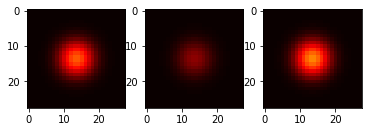

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.153672456741333, dimming (predicted): 0.09928130358457565


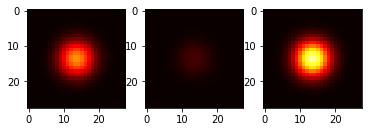

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5520182847976685, dimming (predicted): 0.572265625


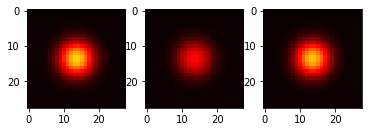

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.24416565895080566, dimming (predicted): 0.1950770765542984


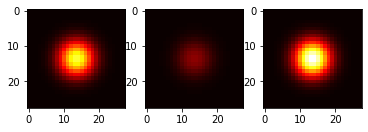

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7679734230041504, dimming (predicted): 0.7938308119773865


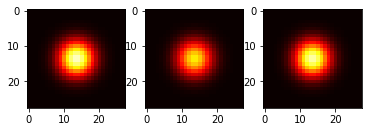

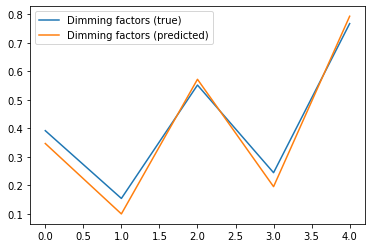

Current loss: 0.02538466453552246
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09534388780593872, dimming (predicted): 0.09273556619882584


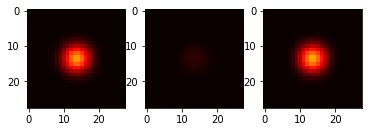

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.24002939462661743, dimming (predicted): 0.2476987987756729


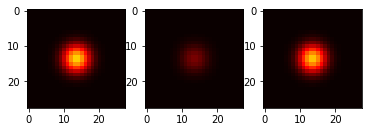

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6078426837921143, dimming (predicted): 0.6291715502738953


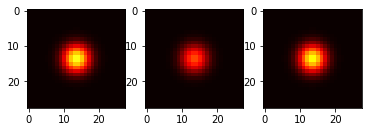

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.12129777669906616, dimming (predicted): 0.15259245038032532


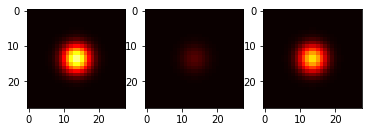

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5306251049041748, dimming (predicted): 0.4860655665397644


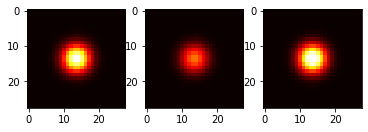

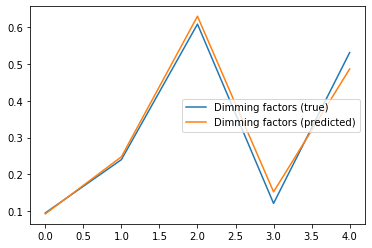

Current loss: 0.003095499239861965
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.054941534996032715, dimming (predicted): 0.10162938386201859


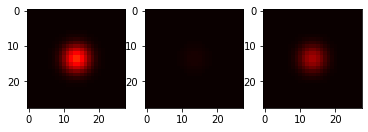

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.13589626550674438, dimming (predicted): 0.1441332995891571


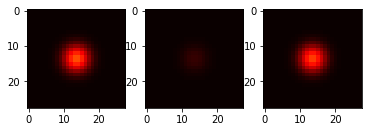

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5216012597084045, dimming (predicted): 0.5391377210617065


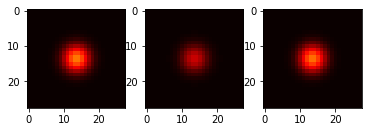

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.49175339937210083, dimming (predicted): 0.5547134280204773


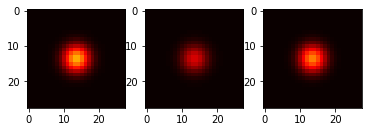

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7829747200012207, dimming (predicted): 0.7931914329528809


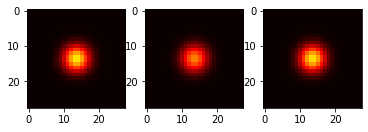

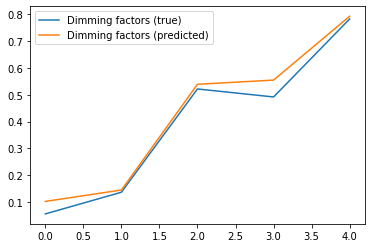

Current loss: 0.02263728156685829
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4535170793533325, dimming (predicted): 0.37535789608955383


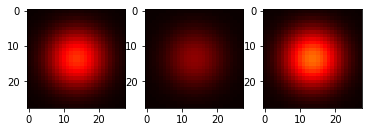

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7545578479766846, dimming (predicted): 0.724137544631958


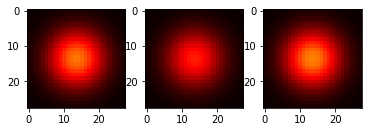

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7220398187637329, dimming (predicted): 0.7665024995803833


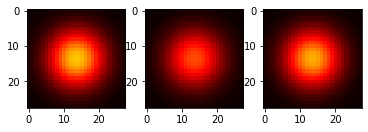

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7362005710601807, dimming (predicted): 0.7777161598205566


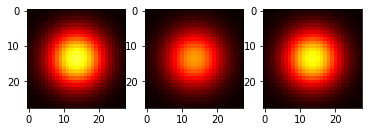

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.10631221532821655, dimming (predicted): 0.059419289231300354


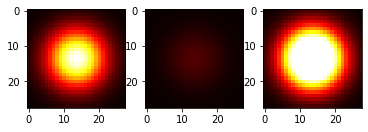

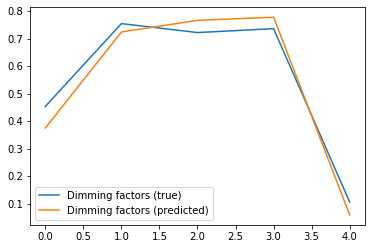

Current loss: 0.013851204887032509
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5037847757339478, dimming (predicted): 0.4232337474822998


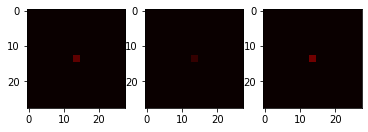

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7271791100502014, dimming (predicted): 0.4965098798274994


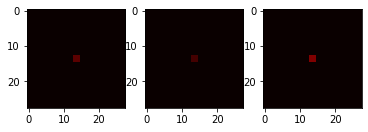

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.267264723777771, dimming (predicted): 0.38652870059013367


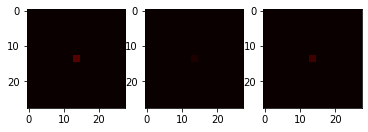

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7589008808135986, dimming (predicted): 0.47087469696998596


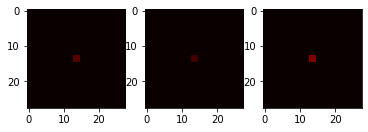

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.0007088184356689453, dimming (predicted): 0.23479612171649933


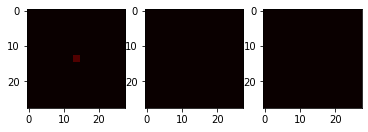

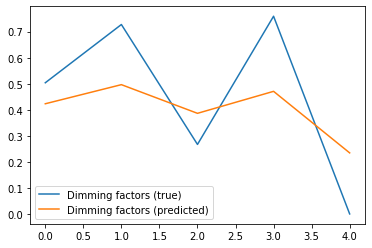

Current loss: 0.0026588754262775183
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7807460427284241, dimming (predicted): 0.7933102250099182


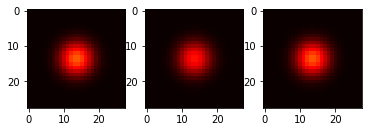

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9148678779602051, dimming (predicted): 0.8525512218475342


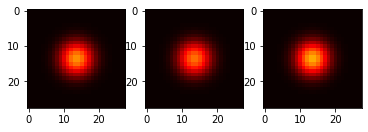

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8098779320716858, dimming (predicted): 0.8675295114517212


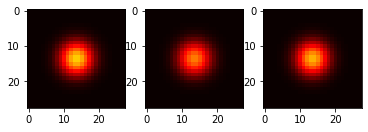

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2743833661079407, dimming (predicted): 0.2886381447315216


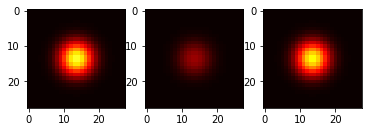

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.14733201265335083, dimming (predicted): 0.12324507534503937


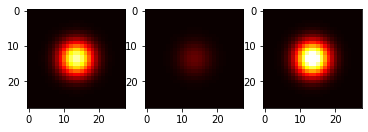

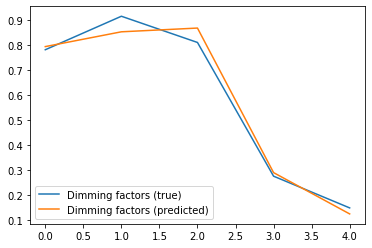

Current loss: 0.016338234767317772
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8493267893791199, dimming (predicted): 0.8177163600921631


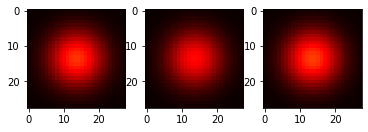

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4494803547859192, dimming (predicted): 0.4151969254016876


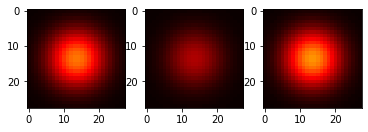

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.32987380027770996, dimming (predicted): 0.2712640166282654


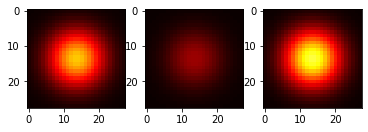

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3920591473579407, dimming (predicted): 0.29750582575798035


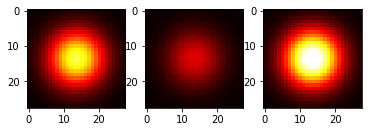

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.46171289682388306, dimming (predicted): 0.42235562205314636


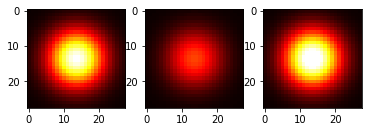

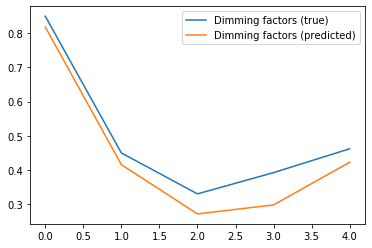

Current loss: 0.010255021043121815
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.95127934217453, dimming (predicted): 0.8514965772628784


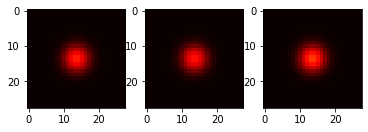

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3066616654396057, dimming (predicted): 0.18270450830459595


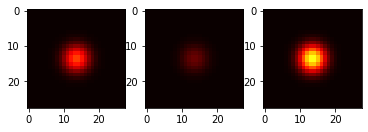

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.48746395111083984, dimming (predicted): 0.3217867314815521


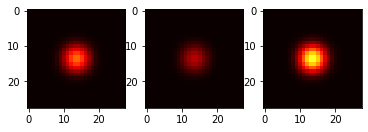

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.30363893508911133, dimming (predicted): 0.1772511750459671


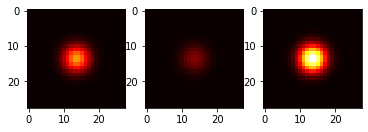

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09903764724731445, dimming (predicted): 0.07216151058673859


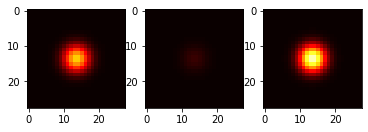

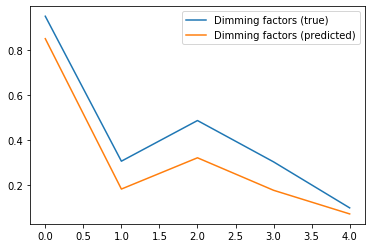

Current loss: 0.0156655702739954
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.019275307655334473, dimming (predicted): 0.07330718636512756


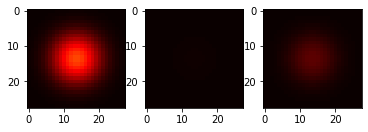

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6632441282272339, dimming (predicted): 0.7906872034072876


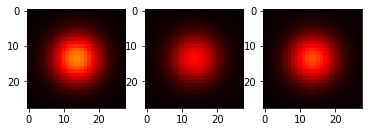

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7677825093269348, dimming (predicted): 0.7502333521842957


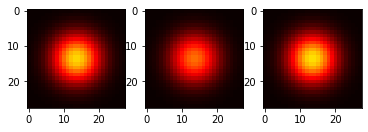

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6948251724243164, dimming (predicted): 0.7441797256469727


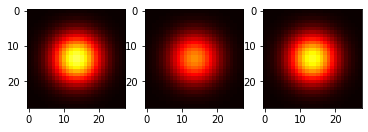

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.77121502161026, dimming (predicted): 0.744118869304657


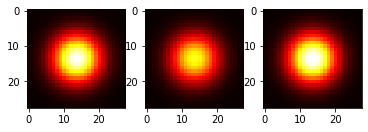

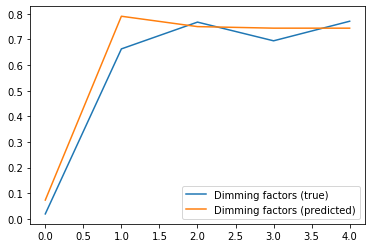

Current loss: 0.0031321425922214985
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09105414152145386, dimming (predicted): 0.07662787288427353


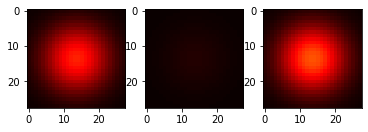

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5152799487113953, dimming (predicted): 0.5474298596382141


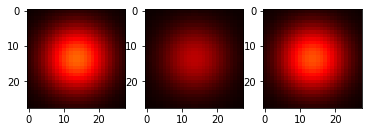

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6705030798912048, dimming (predicted): 0.6490010023117065


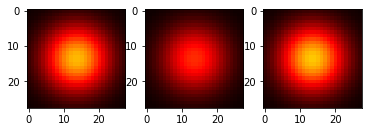

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4880550503730774, dimming (predicted): 0.46827924251556396


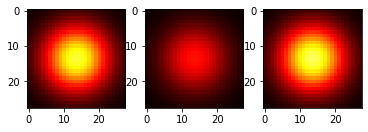

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.781109094619751, dimming (predicted): 0.7223870158195496


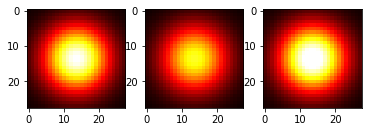

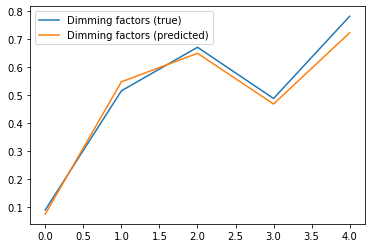

Current loss: 0.004111009184271097
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.34469449520111084, dimming (predicted): 0.2984590232372284


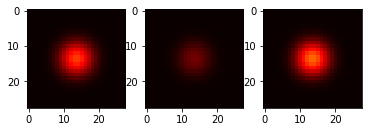

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4686392545700073, dimming (predicted): 0.4374482035636902


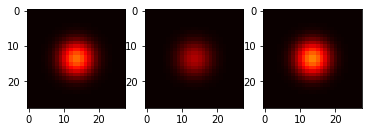

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.894536554813385, dimming (predicted): 0.8488954305648804


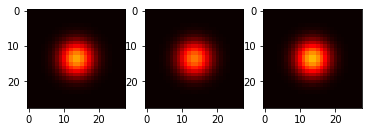

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5909699201583862, dimming (predicted): 0.6254100203514099


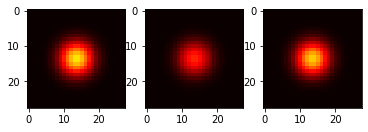

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.20205742120742798, dimming (predicted): 0.20642052590847015


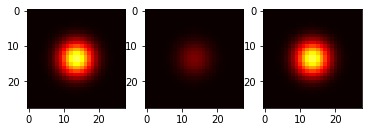

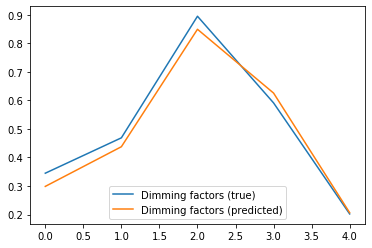

Current loss: 0.002811081474646926
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8420985341072083, dimming (predicted): 0.7500762939453125


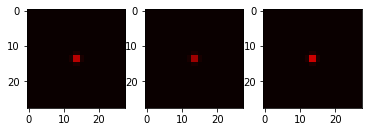

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9654600024223328, dimming (predicted): 0.8583735227584839


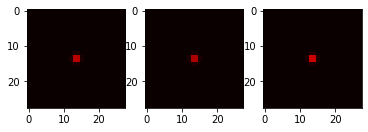

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8027230501174927, dimming (predicted): 0.7155523896217346


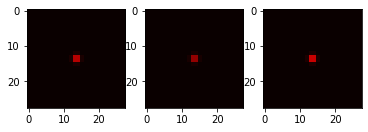

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.822622537612915, dimming (predicted): 0.7917376756668091


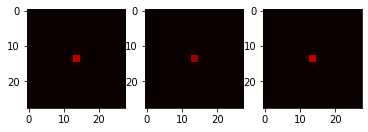

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.025144219398498535, dimming (predicted): 0.11095534265041351


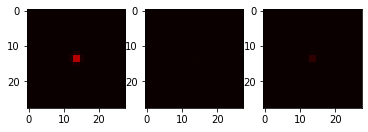

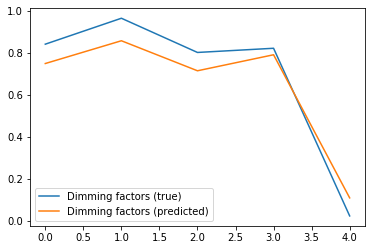

Current loss: 0.0029974845238029957
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.03640007972717285, dimming (predicted): 0.049676313996315


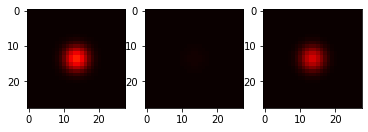

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9739250540733337, dimming (predicted): 0.9146245718002319


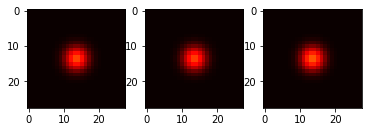

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.20855355262756348, dimming (predicted): 0.15136951208114624


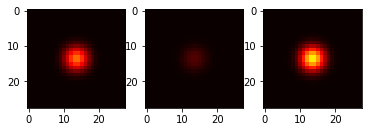

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.21684086322784424, dimming (predicted): 0.14970086514949799


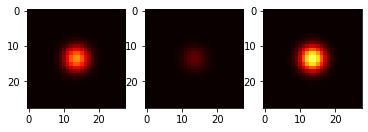

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7476414442062378, dimming (predicted): 0.7163684964179993


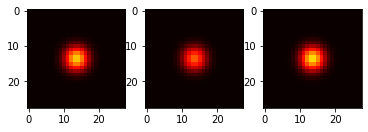

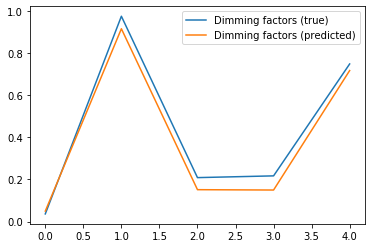

Current loss: 0.003175069112330675
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5280047059059143, dimming (predicted): 0.4268767535686493


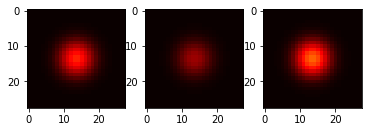

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.32557570934295654, dimming (predicted): 0.3254924416542053


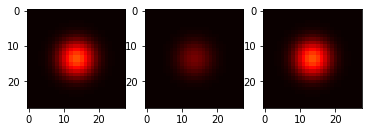

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9056757092475891, dimming (predicted): 0.8597875237464905


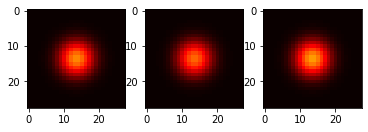

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.044239819049835205, dimming (predicted): 0.06070234626531601


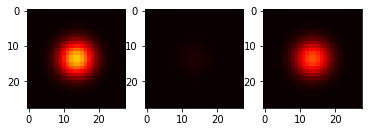

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1958545446395874, dimming (predicted): 0.16636326909065247


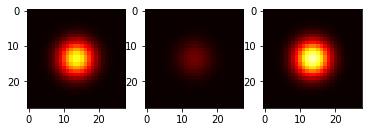

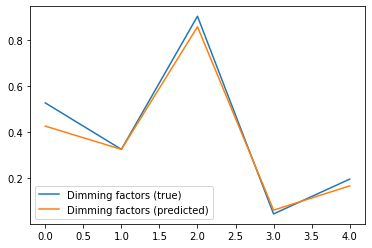

Current loss: 0.006678397301584482
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.07568252086639404, dimming (predicted): 0.09835246950387955


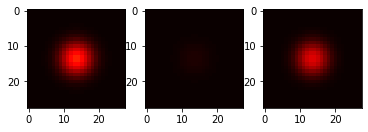

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5931870341300964, dimming (predicted): 0.7239994406700134


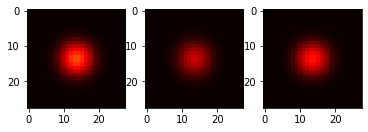

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.001200556755065918, dimming (predicted): 0.06992153823375702


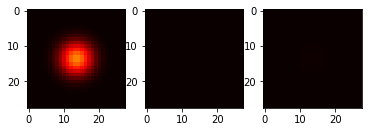

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.04371088743209839, dimming (predicted): 0.11348128318786621


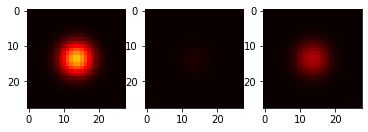

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3721150755882263, dimming (predicted): 0.29278725385665894


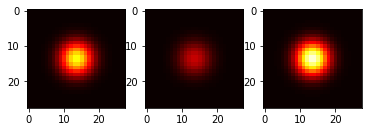

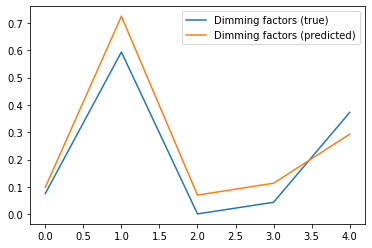

Current loss: 0.0400703027844429
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3710210919380188, dimming (predicted): 0.47608670592308044


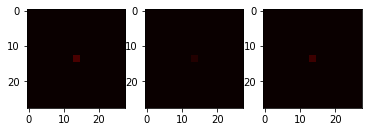

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.026881158351898193, dimming (predicted): 0.2714310586452484


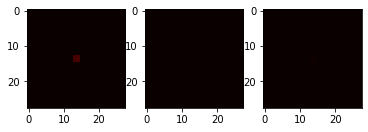

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8043898940086365, dimming (predicted): 0.44344019889831543


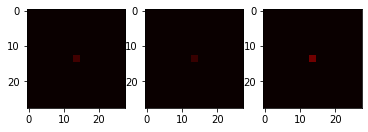

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7590628266334534, dimming (predicted): 0.4589135944843292


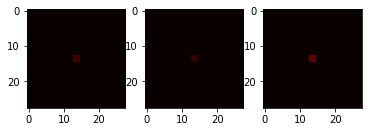

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.05100810527801514, dimming (predicted): 0.3689197599887848


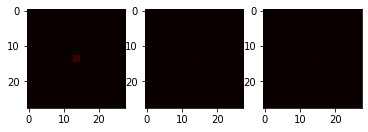

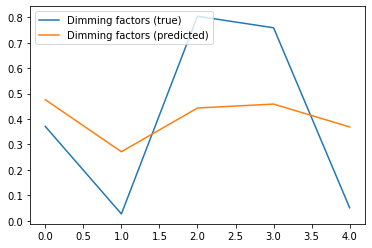

Current loss: 0.003749814350157976
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7396203875541687, dimming (predicted): 0.8067334294319153


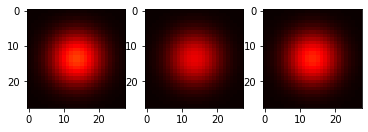

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7267698049545288, dimming (predicted): 0.7278455495834351


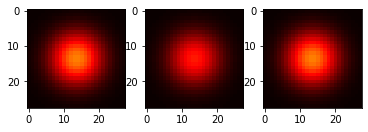

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4207417964935303, dimming (predicted): 0.48255306482315063


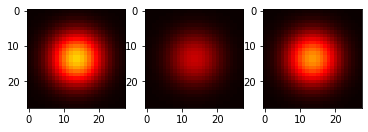

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.11542022228240967, dimming (predicted): 0.18765513598918915


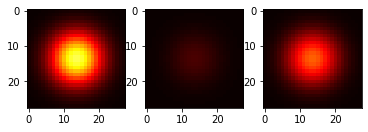

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.35498160123825073, dimming (predicted): 0.38708409667015076


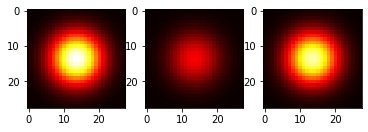

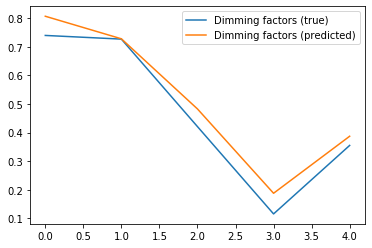

Current loss: 0.002971099689602852
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9487707018852234, dimming (predicted): 0.8320329785346985


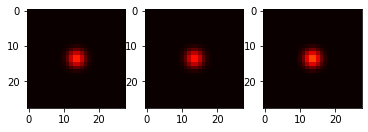

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8088743090629578, dimming (predicted): 0.8450807929039001


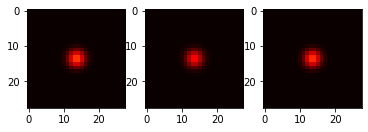

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5076212286949158, dimming (predicted): 0.4138931334018707


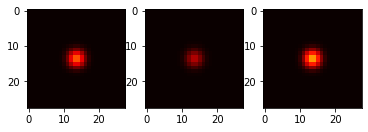

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9580474495887756, dimming (predicted): 0.8506765365600586


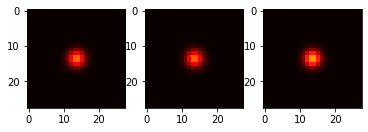

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7342798113822937, dimming (predicted): 0.7367909550666809


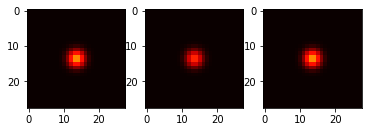

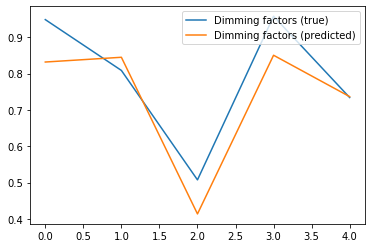

Current loss: 0.0022635452914983034
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.023022592067718506, dimming (predicted): 0.051133815199136734


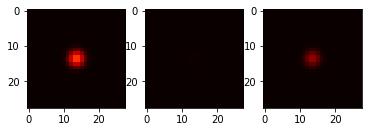

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6924751400947571, dimming (predicted): 0.6702226996421814


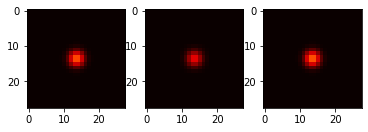

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6130748391151428, dimming (predicted): 0.6369543075561523


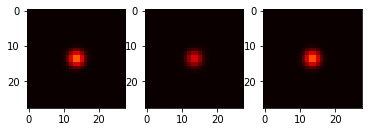

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.33217567205429077, dimming (predicted): 0.27428388595581055


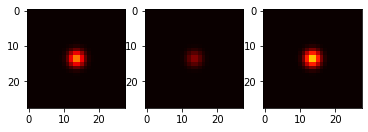

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.08823341131210327, dimming (predicted): 0.06462455540895462


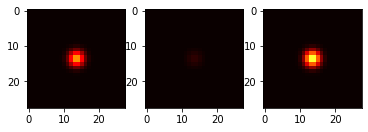

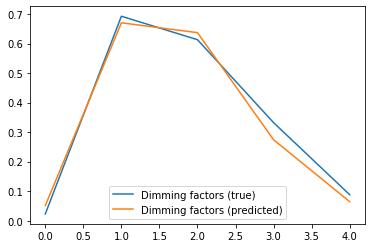

Current loss: 0.012226944789290428
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.655272901058197, dimming (predicted): 0.6388759016990662


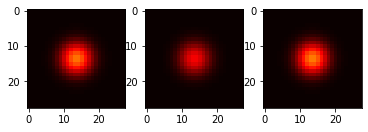

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.32702815532684326, dimming (predicted): 0.3737230896949768


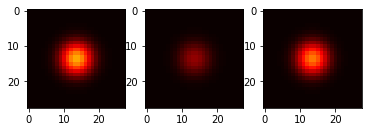

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6157447099685669, dimming (predicted): 0.6804426312446594


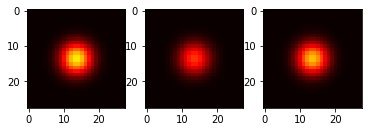

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9295250773429871, dimming (predicted): 0.8390207886695862


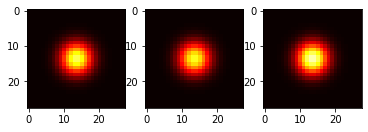

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.944728672504425, dimming (predicted): 0.9143595695495605


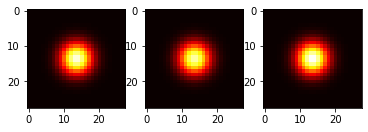

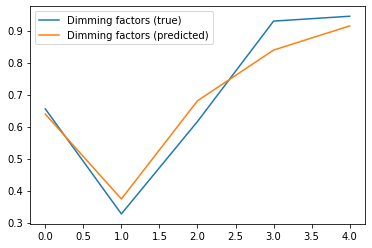

Current loss: 0.011295890435576439
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5562466382980347, dimming (predicted): 0.6438809037208557


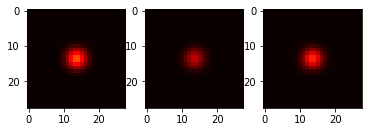

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.46617239713668823, dimming (predicted): 0.43056797981262207


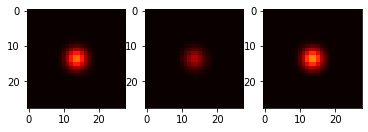

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.06966155767440796, dimming (predicted): 0.10777422785758972


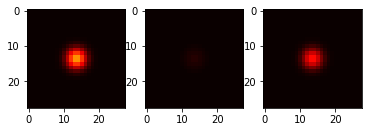

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.08992254734039307, dimming (predicted): 0.08699525892734528


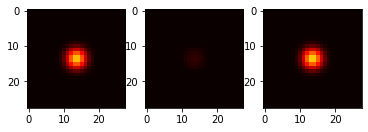

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9155204892158508, dimming (predicted): 0.8746061325073242


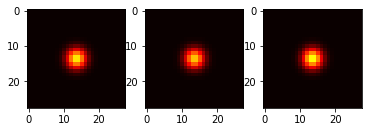

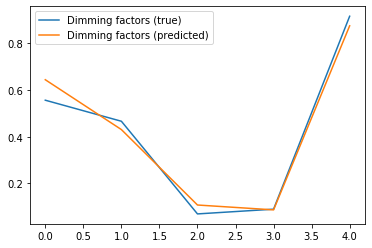

Current loss: 0.004599438514560461
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1899154782295227, dimming (predicted): 0.12087884545326233


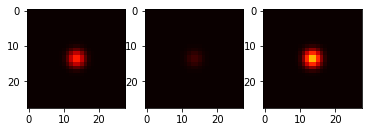

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6614382863044739, dimming (predicted): 0.7154823541641235


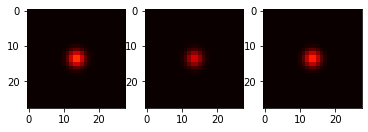

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5888481736183167, dimming (predicted): 0.5396773815155029


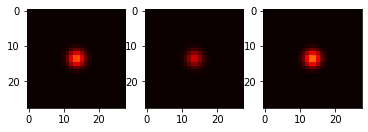

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3816591501235962, dimming (predicted): 0.3466629981994629


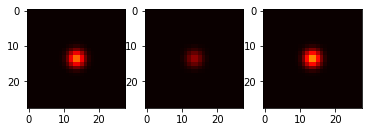

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9040388464927673, dimming (predicted): 0.8843582272529602


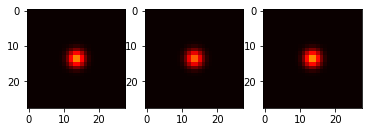

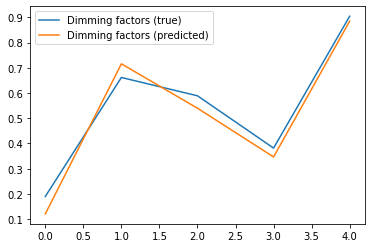

Current loss: 0.013694999739527702
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.46529197692871094, dimming (predicted): 0.5391990542411804


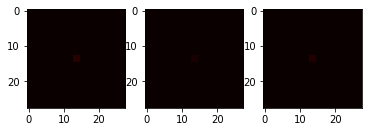

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2707018256187439, dimming (predicted): 0.5503097176551819


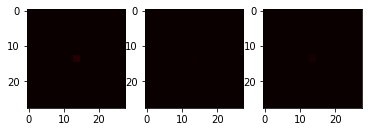

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5883458852767944, dimming (predicted): 0.5385096073150635


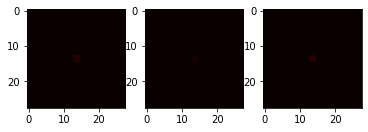

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.711223840713501, dimming (predicted): 0.6562264561653137


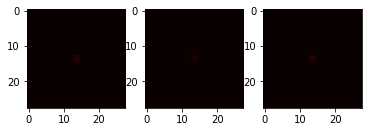

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.12367808818817139, dimming (predicted): 0.4995032846927643


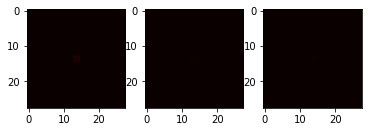

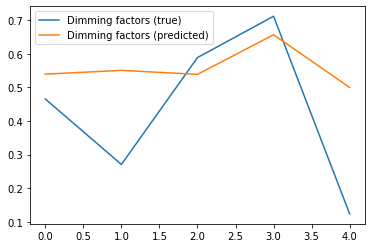

Current loss: 0.009123732335865498
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.24880725145339966, dimming (predicted): 0.31390345096588135


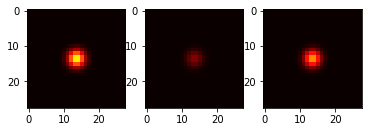

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09860312938690186, dimming (predicted): 0.1614205241203308


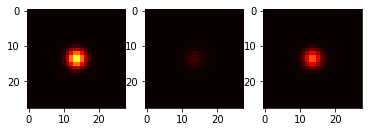

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.0005053877830505371, dimming (predicted): 0.13207031786441803


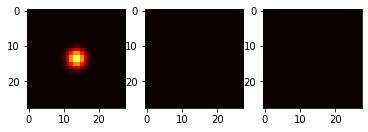

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3067225217819214, dimming (predicted): 0.36745989322662354


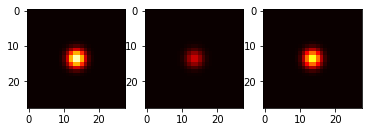

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6047800183296204, dimming (predicted): 0.695736825466156


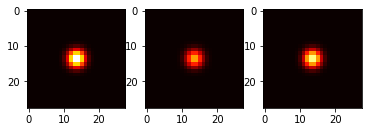

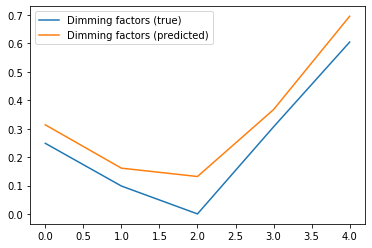

Current loss: 0.018941473215818405
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.11268466711044312, dimming (predicted): 0.09128105640411377


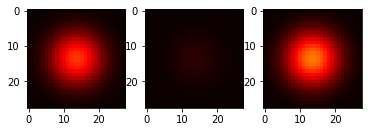

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3262483477592468, dimming (predicted): 0.3026646673679352


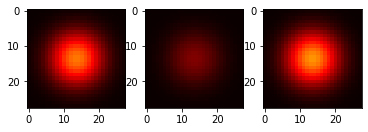

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7689578533172607, dimming (predicted): 0.8096997141838074


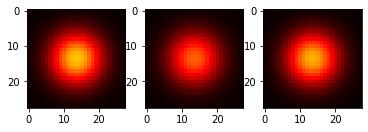

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1291777491569519, dimming (predicted): 0.10421857237815857


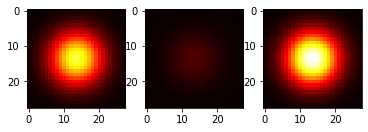

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.008132755756378174, dimming (predicted): 0.05906800180673599


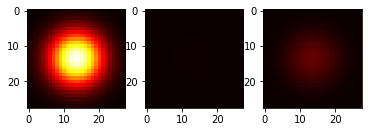

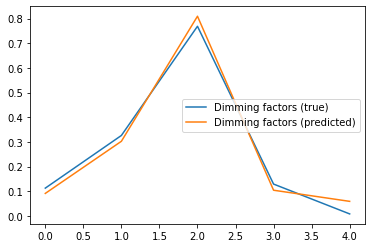

Current loss: 0.03159213811159134
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.07674998044967651, dimming (predicted): 0.5586921572685242


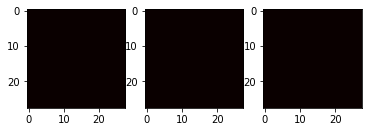

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3407534956932068, dimming (predicted): 0.45899584889411926


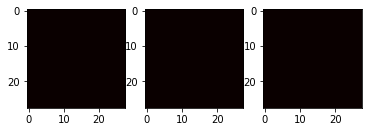

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.03845757246017456, dimming (predicted): 0.5935323238372803


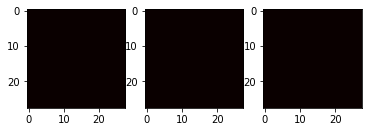

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3655357360839844, dimming (predicted): 0.5978178977966309


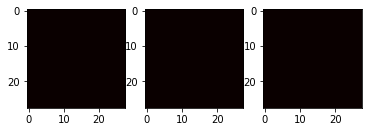

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6115505695343018, dimming (predicted): 0.5991548895835876


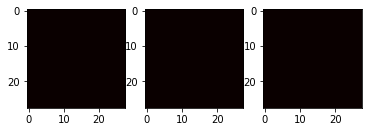

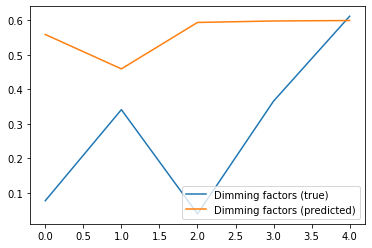

Current loss: 0.03158315643668175
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7806574106216431, dimming (predicted): 0.7987483143806458


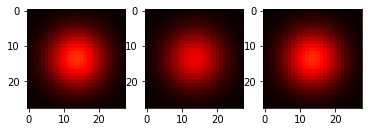

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.13365435600280762, dimming (predicted): 0.07677944004535675


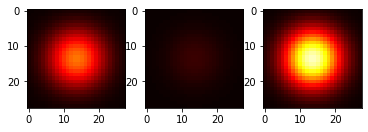

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3986912965774536, dimming (predicted): 0.3570019602775574


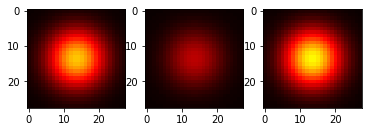

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2822314500808716, dimming (predicted): 0.22404856979846954


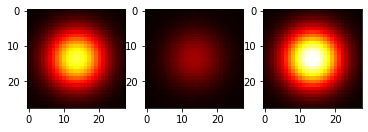

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09700322151184082, dimming (predicted): 0.07896970957517624


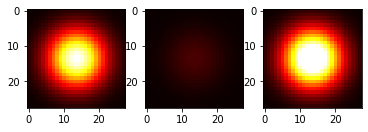

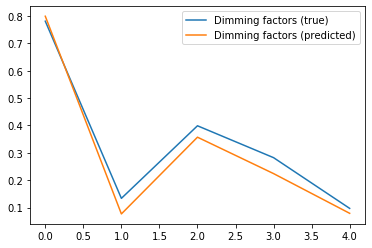

Current loss: 0.017905812710523605
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7610307931900024, dimming (predicted): 0.44016221165657043


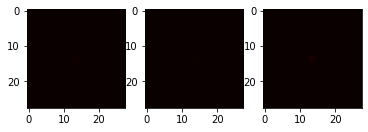

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.43906980752944946, dimming (predicted): 0.2892700731754303


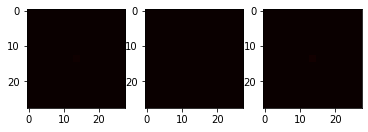

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3702392578125, dimming (predicted): 0.48599815368652344


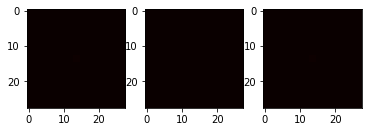

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8673611879348755, dimming (predicted): 0.4564051926136017


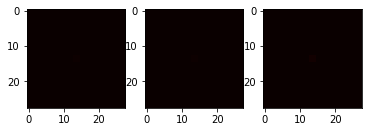

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5220597386360168, dimming (predicted): 0.42723968625068665


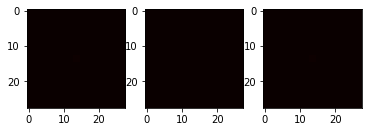

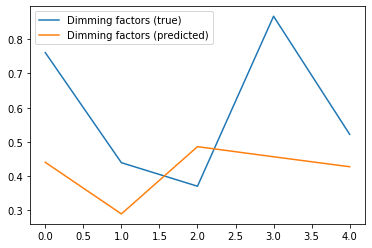

Current loss: 0.003014596877619624
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.20625078678131104, dimming (predicted): 0.18114706873893738


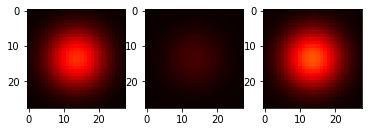

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4687027931213379, dimming (predicted): 0.403852254152298


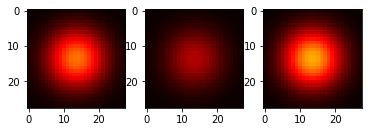

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.150385320186615, dimming (predicted): 0.15064845979213715


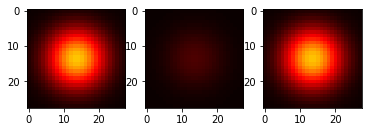

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.18848282098770142, dimming (predicted): 0.07567638158798218


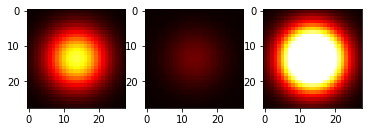

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9274919629096985, dimming (predicted): 0.8883379101753235


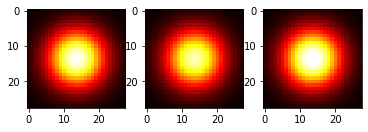

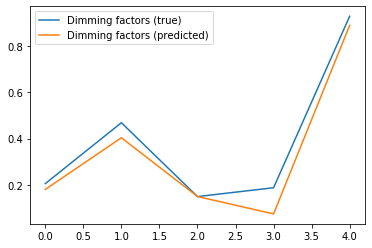

Current loss: 0.00215328810736537
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8735877275466919, dimming (predicted): 0.87163907289505


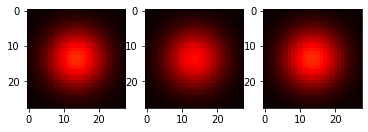

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.47627097368240356, dimming (predicted): 0.4840191900730133


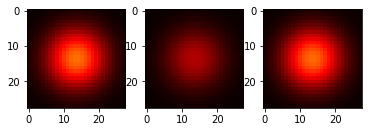

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6614452004432678, dimming (predicted): 0.6315123438835144


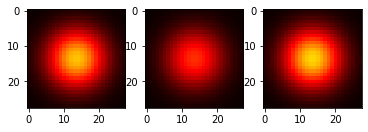

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2638099193572998, dimming (predicted): 0.2507512867450714


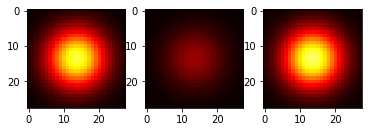

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.08006405830383301, dimming (predicted): 0.09693155437707901


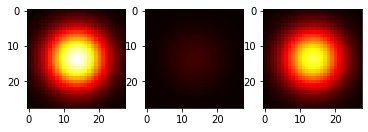

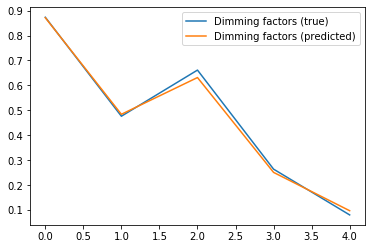

Current loss: 0.006174629088491201
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6097047328948975, dimming (predicted): 0.6268987655639648


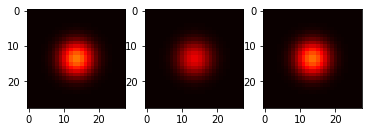

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.030360281467437744, dimming (predicted): 0.07843087613582611


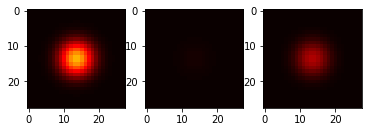

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7963094711303711, dimming (predicted): 0.7577986717224121


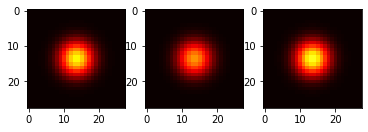

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4297980070114136, dimming (predicted): 0.413885235786438


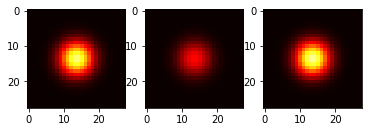

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.33377784490585327, dimming (predicted): 0.32878634333610535


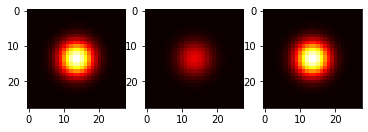

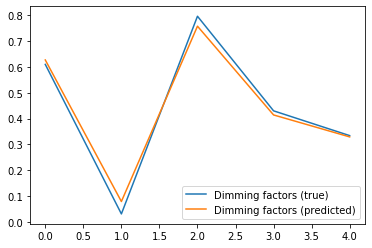

Current loss: 0.0017261445755138993
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7803325653076172, dimming (predicted): 0.7634913325309753


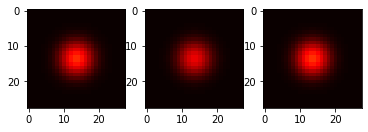

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.14938819408416748, dimming (predicted): 0.14754094183444977


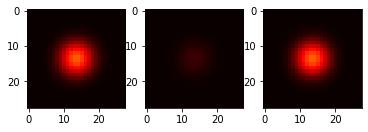

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8159007430076599, dimming (predicted): 0.8308161497116089


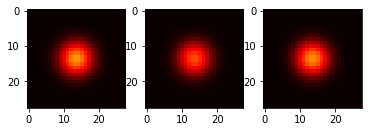

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6839943528175354, dimming (predicted): 0.6566874384880066


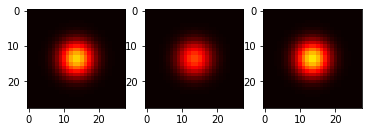

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3865642547607422, dimming (predicted): 0.41690346598625183


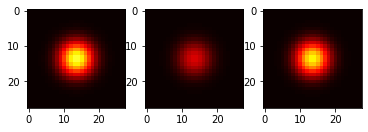

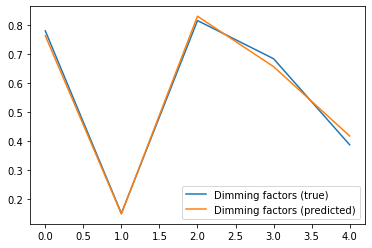

Current loss: 0.006437266711145639
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7869657278060913, dimming (predicted): 0.8403791785240173


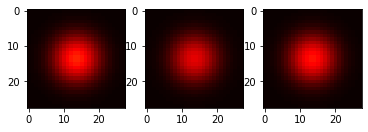

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5328220725059509, dimming (predicted): 0.5554336905479431


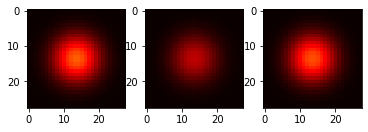

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5774997472763062, dimming (predicted): 0.5923565030097961


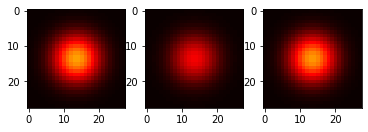

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9366853833198547, dimming (predicted): 0.8985483050346375


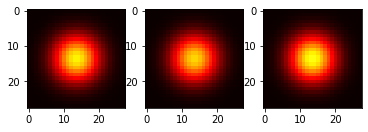

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.1588670015335083, dimming (predicted): 0.10244931280612946


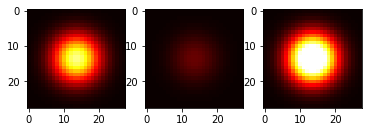

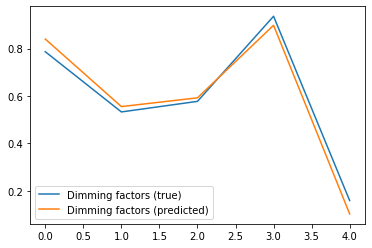

Current loss: 0.006293885409832001
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.01798391342163086, dimming (predicted): 0.09234241396188736


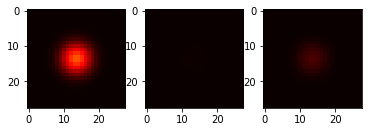

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.14447522163391113, dimming (predicted): 0.20866939425468445


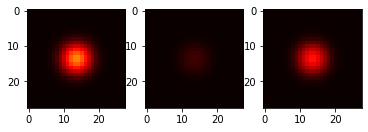

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3037188649177551, dimming (predicted): 0.28679484128952026


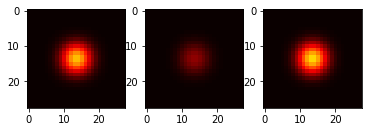

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6509882211685181, dimming (predicted): 0.718333899974823


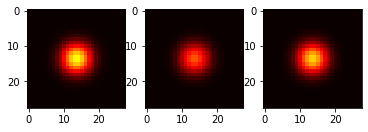

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.12890267372131348, dimming (predicted): 0.11405543982982635


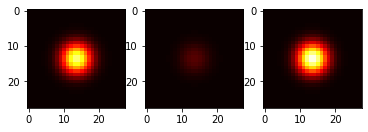

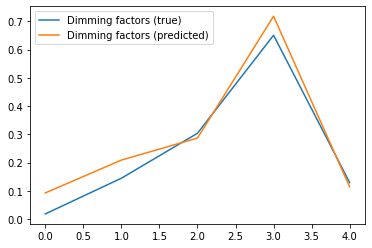

Current loss: 0.005462220869958401
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4234616160392761, dimming (predicted): 0.47587108612060547


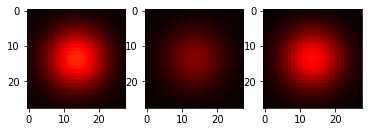

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.6753214001655579, dimming (predicted): 0.7610961198806763


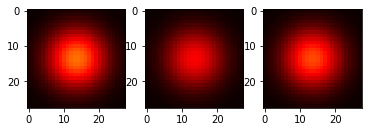

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.4079035520553589, dimming (predicted): 0.4957652688026428


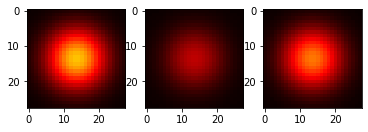

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8154578804969788, dimming (predicted): 0.9132711291313171


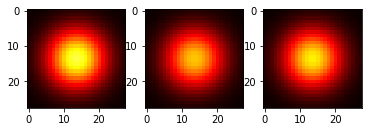

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.8221363425254822, dimming (predicted): 0.9083991050720215


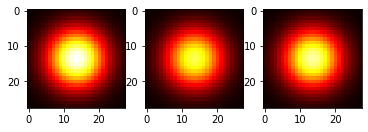

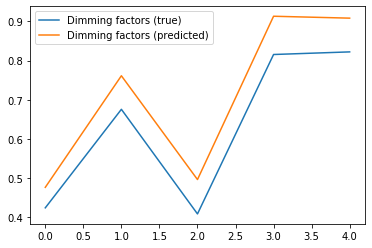

Current loss: 0.0031167727429419756
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.051531970500946045, dimming (predicted): 0.12746454775333405


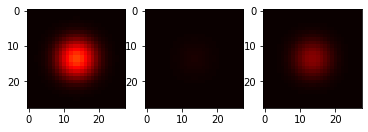

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.08290630578994751, dimming (predicted): 0.13286274671554565


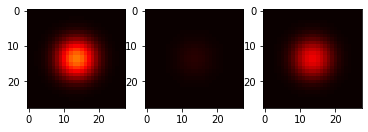

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.22596228122711182, dimming (predicted): 0.24297413229942322


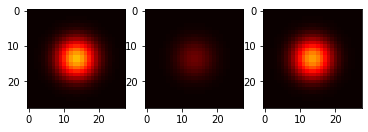

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.03376114368438721, dimming (predicted): 0.09727275371551514


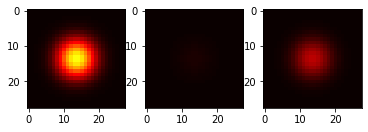

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5574544668197632, dimming (predicted): 0.6250948309898376


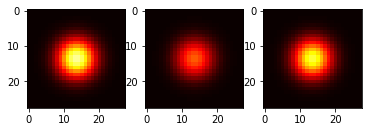

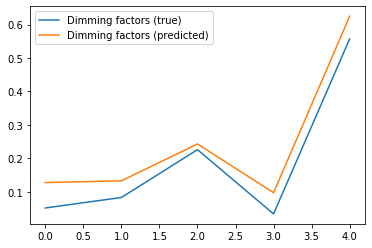

Current loss: 0.0025381287559866905
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.5928807854652405, dimming (predicted): 0.72478187084198


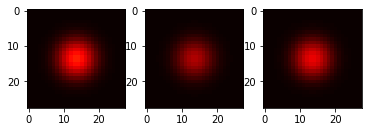

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.3531433939933777, dimming (predicted): 0.37859541177749634


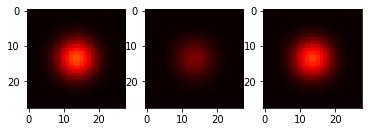

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.38089823722839355, dimming (predicted): 0.3787651062011719


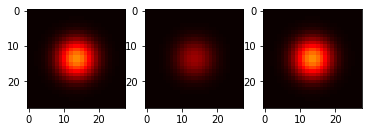

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.09115397930145264, dimming (predicted): 0.1383226066827774


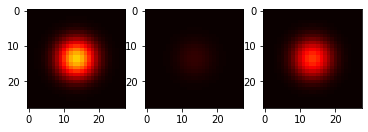

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.40885043144226074, dimming (predicted): 0.35854917764663696


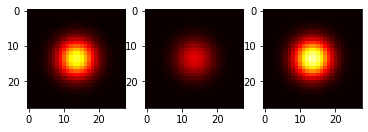

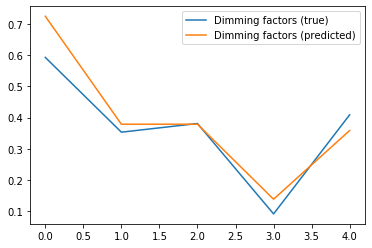

Current loss: 0.0036788322031497955
Channel: 0 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.7892206907272339, dimming (predicted): 0.7348789572715759


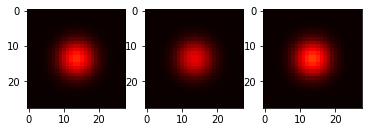

Channel: 1 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.2539716958999634, dimming (predicted): 0.19744016230106354


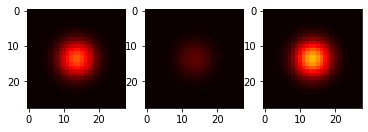

Channel: 2 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.9599076509475708, dimming (predicted): 0.8762068152427673


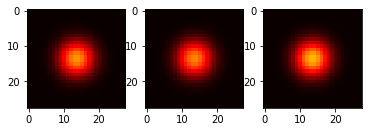

Channel: 3 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.13735151290893555, dimming (predicted): 0.12586592137813568


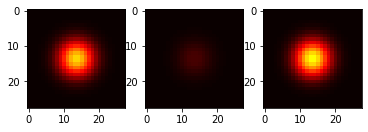

Channel: 4 (left: original, middle: dimmed, right: undimmed)
Dimming (true): 0.48954516649246216, dimming (predicted): 0.4567900598049164


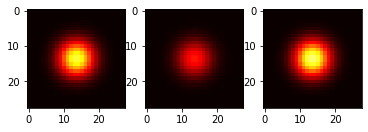

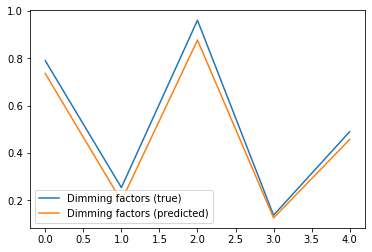

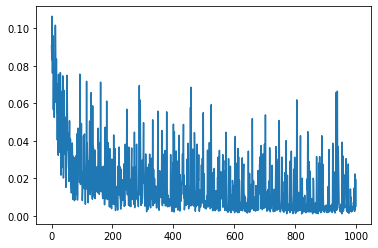

Loss min: 0.0010526215191930532, max: 0.10633864253759384, mean: 0.01697537757270038


----- Experiment Run 2
input_channels: 5
cnn_output_dim: 512
Current loss: 0.11621218919754028
Current loss: 0.07688561826944351
Current loss: 0.06309274584054947
Current loss: 0.03534882143139839
Current loss: 0.07581719756126404
Current loss: 0.056742191314697266
Current loss: 0.029988721013069153
Current loss: 0.020241808146238327
Current loss: 0.04508566856384277
Current loss: 0.03539147973060608
Current loss: 0.03237093985080719
Current loss: 0.06332854181528091
Current loss: 0.01150061096996069
Current loss: 0.024383557960391045
Current loss: 0.010571124963462353
Current loss: 0.03725080564618111
Current loss: 0.024487148970365524
Current loss: 0.014702136628329754
Current loss: 0.004247077740728855
Current loss: 0.009151116944849491
Current loss: 0.015996236354112625
Current loss: 0.013078240677714348
Current loss: 0.030885979533195496
Current loss: 0.015972787514328957
Current loss: 0.0323124

In [15]:
def make_sun_upperleft(num_channels):
    size = 28
    xx, yy = np.meshgrid(np.arange(size)-(size-1)/2.,np.arange(size)-(size-1)/2)
    r = np.sqrt(xx*xx+yy*yy) 
    R = np.random.rand(1)*(size/3)
    channels = []
    for c in range(num_channels):
        I_c = R**(c/10.)
        channels.append(np.exp(-(r*r)/(R*R))*I_c)
    image = torch.cat([torch.from_numpy(channel).float().to(device) for channel in channels]).view(num_channels, 28, 28)
    return image

means = np.zeros((experiments_count,), dtype=np.float32)
for experiment in range(1, experiments_count + 1):
  print('\n\n----- Experiment Run {}'.format(experiment))
  debug_out = True if experiment == 1 else False
  means[experiment - 1] = run_experiment("upperleft_mean", make_sun_upperleft, debug_out)

print('\n\nFinal mean after {} runs: {}'.format(experiments_count, means.mean()))
upperleft_mean = means.mean()

In [16]:
def make_sun_lowerleft(num_channels):
    size = 28
    xx, yy = np.meshgrid(np.arange(size)-(size-1)/2.,np.arange(size)-(size-1)/2)
    r = np.sqrt(xx*xx+yy*yy) 
    R = np.random.rand(1)*(size/3)
    channels = []
    for c in range(num_channels):
        random_channel = np.random.randint(num_channels)
        I_c = R ** (random_channel/10.)
        channels.append(np.exp(-(r*r)/(R*R))*I_c)
    image = torch.cat([torch.from_numpy(channel).float().to(device) for channel in channels]).view(num_channels, 28, 28)
    return image

means = np.zeros((experiments_count,), dtype=np.float32)
for experiment in range(1, experiments_count + 1):
  print('\n\n----- Experiment Run {}'.format(experiment))
  means[experiment - 1] = run_experiment("lowerleft_mean", make_sun_lowerleft)

print('\n\nFinal mean after {} runs: {}'.format(experiments_count, means.mean()))
lowerleft_mean = means.mean()



----- Experiment Run 1
input_channels: 5
cnn_output_dim: 512
Current loss: 0.10076568275690079
Current loss: 0.07011522352695465
Current loss: 0.0789531022310257
Current loss: 0.06107329577207565
Current loss: 0.07202456891536713
Current loss: 0.018469568341970444
Current loss: 0.02927936241030693
Current loss: 0.09790437668561935
Current loss: 0.02980654314160347
Current loss: 0.03875746950507164
Current loss: 0.04565036669373512
Current loss: 0.04253043979406357
Current loss: 0.026602506637573242
Current loss: 0.038431357592344284
Current loss: 0.0394529290497303
Current loss: 0.021821709349751472
Current loss: 0.08579455316066742
Current loss: 0.019230041652917862
Current loss: 0.027222299948334694
Current loss: 0.028309887275099754
Current loss: 0.02647874876856804
Current loss: 0.020654167979955673
Current loss: 0.040448740124702454
Current loss: 0.0206015482544899
Current loss: 0.036523301154375076
Current loss: 0.012618469074368477
Current loss: 0.012207118794322014
Current lo

In [17]:
def make_sun_upperright(num_channels):
    size = 28
    xx, yy = np.meshgrid(np.arange(size)-(size-1)/2.,np.arange(size)-(size-1)/2)
    r = np.sqrt(xx*xx+yy*yy) 
    R = np.random.rand(1)*(size/3)
    channels = []
    I_0 = np.random.rand() * 1000.
    for c in range(num_channels):
        I_c = I_0**(c/10.)
        channels.append(np.exp(-(r*r)/(R*R))*I_c)
    image = torch.cat([torch.from_numpy(channel).float().to(device) for channel in channels]).view(num_channels, 28, 28)
    return image

means = np.zeros((experiments_count,), dtype=np.float32)
for experiment in range(1, experiments_count + 1):
  print('\n\n----- Experiment Run {}'.format(experiment))
  means[experiment - 1] = run_experiment("upperright_mean", make_sun_upperright)

print('\n\nFinal mean after {} runs: {}'.format(experiments_count, means.mean()))
upperright_mean = means.mean()



----- Experiment Run 1
input_channels: 5
cnn_output_dim: 512
Current loss: 0.08657228201627731
Current loss: 0.05105821043252945
Current loss: 0.04915093630552292
Current loss: 0.04809527099132538
Current loss: 0.08585597574710846
Current loss: 0.05838238447904587
Current loss: 0.06091234087944031
Current loss: 0.019702546298503876
Current loss: 0.0713304653763771
Current loss: 0.04088560864329338
Current loss: 0.022059712558984756
Current loss: 0.044612281024456024
Current loss: 0.03992185741662979
Current loss: 0.02653765119612217
Current loss: 0.009287634864449501
Current loss: 0.02182171866297722
Current loss: 0.02167944237589836
Current loss: 0.04354202002286911
Current loss: 0.008060120977461338
Current loss: 0.011702842079102993
Current loss: 0.048090580850839615
Current loss: 0.008525671437382698
Current loss: 0.01717185601592064
Current loss: 0.008141922764480114
Current loss: 0.01415865309536457
Current loss: 0.011295833624899387
Current loss: 0.031843140721321106
Current l

In [18]:
def make_sun_lowerright(num_channels):
    size = 28
    xx, yy = np.meshgrid(np.arange(size)-(size-1)/2.,np.arange(size)-(size-1)/2)
    r = np.sqrt(xx*xx+yy*yy) 
    R = np.random.rand(1)*(size/3)
    channels = []
    for c in range(num_channels):
        random_channel = np.random.randint(num_channels)
        random_luminance = np.random.rand() * 1000. 
        I_c = random_luminance ** (random_channel/10.)
        channels.append(np.exp(-(r*r)/(R*R))*I_c)
    image = torch.cat([torch.from_numpy(channel).float().to(device) for channel in channels]).view(num_channels, 28, 28)
    return image

means = np.zeros((experiments_count,), dtype=np.float32)
for experiment in range(1, experiments_count + 1):
  print('\n\n----- Experiment Run {}'.format(experiment))
  means[experiment - 1] = run_experiment("lowerright_mean", make_sun_lowerright)

print('\n\nFinal mean after {} runs: {}'.format(experiments_count, means.mean()))
lowerright_mean = means.mean()



----- Experiment Run 1
input_channels: 5
cnn_output_dim: 512
Current loss: 0.06952033191919327
Current loss: 0.07063160091638565
Current loss: 0.0819627195596695
Current loss: 0.06609616428613663
Current loss: 0.04569646716117859
Current loss: 0.07293450832366943
Current loss: 0.06622742116451263
Current loss: 0.08591320365667343
Current loss: 0.05220205336809158
Current loss: 0.07267352193593979
Current loss: 0.07063699513673782
Current loss: 0.08323685824871063
Current loss: 0.08309276401996613
Current loss: 0.10157473385334015
Current loss: 0.07297150790691376
Current loss: 0.08039826154708862
Current loss: 0.07823566347360611
Current loss: 0.0735606998205185
Current loss: 0.0593411922454834
Current loss: 0.06411917507648468
Current loss: 0.04482392221689224
Current loss: 0.07231482118368149
Current loss: 0.028181860223412514
Current loss: 0.07119453698396683
Current loss: 0.0769544392824173
Current loss: 0.0910821333527565
Current loss: 0.0874113142490387
Current loss: 0.08858229

In [19]:
print('Cross correlation YES/Luminance related to size & shape YES: average mean {}'.format(upperleft_mean))
print('Cross correlation NO /Luminance related to size & shape YES: average mean {}'.format(lowerleft_mean))
print('Cross correlation YES/Luminance related to size & shape NO : average mean {}'.format(upperright_mean))
print('Cross correlation NO /Luminance related to size & shape NO : average mean {}'.format(lowerright_mean))

Cross correlation YES/Luminance related to size & shape YES: average mean 0.016874592751264572
Cross correlation NO /Luminance related to size & shape YES: average mean 0.0272823516279459
Cross correlation YES/Luminance related to size & shape NO : average mean 0.02362300455570221
Cross correlation NO /Luminance related to size & shape NO : average mean 0.06551302969455719
